# Bank Data Analysis
- **Analysis performed by :-** Russel Anthony Reynold Chandanshiv

---

- Copyright (c) 2025 Russel Anthony Reynold Chandanshiv
- Licensed under the MIT License
  
---

# Objective

This project focuses on banking data analysis using PySpark to practice scalable data processing concepts. The goal is to extract, transform, and load global bank market capitalization data, perform currency conversions, and generate insights to support decision-making. A local folder named `s3-storage-bucket` is used to simulate AWS S3 storage for organizing processed outputs, reflecting a typical cloud-based data workflow. This exercise helps build familiarity with Spark-style data pipelines, financial data analysis, and structured ETL processes.


# Business Value

The banking industry operates in a highly competitive and globalized market where financial institutions must continuously monitor their market position, performance, and currency fluctuations. To stay competitive, banks must leverage data-driven insights to optimize their financial strategies, assess market trends, and make informed decisions. I will be analyzing the banking data to uncover patterns in market capitalization, currency conversions, and global rankings. With Apache Spark's ability to handle large datasets efficiently, financial institutions can process vast amounts of data in real-time, helping them make faster and more informed decisions.

In this simulated financial analytics project, the goal is to explore historical banking data and derive key insights that mirror real-world strategic evaluation tasks. The analysis includes identifying the top 10 banks by market capitalization, converting values across major currencies (USD, GBP, EUR, INR), and organizing the processed output for accessible review.

This project simulates cloud storage by creating a local folder named `s3-storage-bucket` to store processed output files, representing how data would typically be organized before uploading to AWS S3.

# Dataset

The data for this project can be accessed from the following [wikipedia link](https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks).

The dataset used in this analysis comprises global banking data extracted from a Wikipedia page (List of Largest Banks) archived as of September 2023.

It includes rankings of the world's largest banks based on market capitalization (in USD billions) and is structured into a single table with three columns. The data was scraped programmatically, cleaned, and transformed using PySpark to support cross-currency analysis. Exchange rate data (for USD, GBP, EUR, and INR) was sourced from a CSV file to enable currency conversions. The processed dataset is stored in CSV and Parquet formats for accessibility and efficient querying.

The dataset consists of a single table (Largest_banks) with the following three key attributes:
- **Rank:** Numerical position of the bank based on market capitalization.
- **Bank Name:** Name of the financial institution.
- **Market Cap (USD Billion):** Market valuation of the bank in USD billions.
This dataset enables analysis of global banking trends, cross-currency valuations, and the relative market dominance of financial institutions.

An additional data on market exchange rates is available to compare the marketcap dealing with different currencies.


**Importing the Required Libraries**

In [1]:
# # Install the required libraries
# !pip install --quiet pyspark==3.5.4 pandas==2.2.2

In [2]:
# Import required libraries
import os
import sys
import time
import logging
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Import PySpark libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, round, count, when, isnull
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Ignore Warnings

warnings.filterwarnings("ignore")


In [3]:
# Check versions
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)


numpy version: 1.24.4
pandas version: 2.0.3
matplotlib version: 3.8.0
seaborn version: 0.13.0


### **1. Data Preparation / Data Extraction** 

The dataset for this project is sourced from a publicly available Wikipedia page containing global banking market capitalization data. The table is extracted into a structured format for further processing. Once loaded, the data is cleaned and prepared to ensure consistency and reliability before analysis.

In [4]:
# Initializing Spark session and Confirming if the Spark Session actually exists.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
try:
    spark = (
             SparkSession.builder 
            .appName("BankingDataAnalysis")
            .getOrCreate()
)
except Exception:
    print ("SparkSession is not currently Active. This is due to {Exception}.")
else:
    if isinstance(spark, SparkSession) and "spark" in locals():
        print ("SparkSession is currently Active.")
        

SparkSession is currently Active.


In [5]:
# Check Spark Version
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print(spark.version)


3.5.0


In [6]:
# Logging Configuration
logfile = "russel_banking_analysis_log.txt"

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging in PySpark
logger4pyspark = logging.getLogger("py4j")
logger4pyspark.setLevel(logging.INFO)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Clear previous handlers (If any) and Do not display logs in notebook
logger4pyspark.handlers.clear()
logger4pyspark.propagate = False

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Custom Logging Function
def log_progress(msg, level="info"):
    """
    Docstring: 
              Take's a message and the level of logging and creates a new file or appends existing file.
              Linked to (py4j logger) for PySpark Logs.
              Default Level for Logging : "INFO"
    Parameters: 
               (Message, Level)
    Arguements: 
               Message can be anything. Level must be valid.
               Level : ["Debug", "Info", "Warning", "Error", "Critical"]

    """
    level = level.upper().strip()

    if level == "DEBUG":
        logger4pyspark.debug(msg)
        
    elif level == "INFO":
        logger4pyspark.info(msg)
        
    elif level == "WARNING":
        logger4pyspark.warning(msg)
        
    elif level == "ERROR":
        logger4pyspark.error(msg)
        
    elif level == "CRITICAL":
        logger4pyspark.critical(msg)
        
    else:
        level = "INFO"
        logger4pyspark.info(msg)

    timeformat = '%Y-%h-%d-%H:%M:%S'
    timestamp = datetime.now().strftime(timeformat)
    with open(logfile, 'a') as f:
        f.write(f"{timestamp} | {level} | {msg}\n")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Recording the Start Time and Logging

start_time = time.time()
log_progress ("Log Setup Completed Successfully : Logs will now be written to log file.")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging the Exact Start Time

timeformat = '%Y-%h-%d-%H:%M:%S'
timestamp = datetime.now().strftime(timeformat)

log_progress (f"Start Time : {timestamp}\n")


In [7]:
# URL of the Wikipedia page
wiki_url = "https://web.archive.org/web/20230908091635/https://en.wikipedia.org/wiki/List_of_largest_banks"
log_progress ("Step 1 : Extraction Phase.\n")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Use pandas to read all HTML tables from the page
try:
    wiki_table = pd.read_html (wiki_url)
except Exception as e:
    log_progress (f"Failed to read webpage due to {e}", "error")
else:
    log_progress ("Webpage read successfully.", "debug")
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Load the correct table (Table 1)
try:
    pandas_df = wiki_table [1]
except Exception as e:
    log_progress (f"No table found. Exception : {e}", "warning")
else:
    log_progress ("Required Table extracted successfully.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Convert pandas DataFrame to PySpark DataFrame
spark_df = spark.createDataFrame(pandas_df)
log_progress ("Spark Banking DataFrame has been created successfully.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Caching the spark dataframe for time-saving and further analysis
spark_df.cache()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Calling an action after caching
spark_df.show(truncate=False)
log_progress ("Extraction of Banking Data from webpage Successful.")


+----+---------------------------------------+------------------------+
|Rank|Bank name                              |Market cap (US$ billion)|
+----+---------------------------------------+------------------------+
|1   |JPMorgan Chase                         |432.92                  |
|2   |Bank of America                        |231.52                  |
|3   |Industrial and Commercial Bank of China|194.56                  |
|4   |Agricultural Bank of China             |160.68                  |
|5   |HDFC Bank                              |157.91                  |
|6   |Wells Fargo                            |155.87                  |
|7   |HSBC Holdings PLC                      |148.9                   |
|8   |Morgan Stanley                         |140.83                  |
|9   |China Construction Bank                |139.82                  |
|10  |Bank of China                          |136.81                  |
+----+---------------------------------------+------------------

In [8]:
# Checking Column Names
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The Column Names (Before Renaming) for our Banking Datset is as follows:-\n")

for index, columns in enumerate (spark_df.columns):
    print (f"Column {index + 1}: {columns}")
    

The Column Names (Before Renaming) for our Banking Datset is as follows:-

Column 1: Rank
Column 2: Bank name
Column 3: Market cap (US$ billion)


In [9]:
# Renaming columns --- as per proper naming conventions
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
spark_df = spark_df.withColumnRenamed("Rank", "global_rank")
spark_df = spark_df.withColumnRenamed("Bank name", "bank_name")
spark_df = spark_df.withColumnRenamed("Market cap (US$ billion)", "market_cap_in_usd_billion")

log_progress ("Columns have been renamed successfully.", "debug")


In [10]:
# Checking column names (after renaming)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The Column Names of the PySpark DataFrame (After Renaming) are as follows:\n")
for index, columns in enumerate (spark_df.columns):
    print (f"Column {index + 1}: {columns}")
    

The Column Names of the PySpark DataFrame (After Renaming) are as follows:

Column 1: global_rank
Column 2: bank_name
Column 3: market_cap_in_usd_billion


In [11]:
# Show the first few rows of the PySpark DataFrame
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The first few rows of the PySpark DataFrame as follows:\n")
spark_df.show(10, truncate=False)


The first few rows of the PySpark DataFrame as follows:

+-----------+---------------------------------------+-------------------------+
|global_rank|bank_name                              |market_cap_in_usd_billion|
+-----------+---------------------------------------+-------------------------+
|1          |JPMorgan Chase                         |432.92                   |
|2          |Bank of America                        |231.52                   |
|3          |Industrial and Commercial Bank of China|194.56                   |
|4          |Agricultural Bank of China             |160.68                   |
|5          |HDFC Bank                              |157.91                   |
|6          |Wells Fargo                            |155.87                   |
|7          |HSBC Holdings PLC                      |148.9                    |
|8          |Morgan Stanley                         |140.83                   |
|9          |China Construction Bank                |139.82    

In [12]:
# Print the schema of the DataFrame
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The Schema of the Spark DataFrame is as follows:\n")
spark_df.printSchema()


The Schema of the Spark DataFrame is as follows:

root
 |-- global_rank: long (nullable = true)
 |-- bank_name: string (nullable = true)
 |-- market_cap_in_usd_billion: double (nullable = true)



*Load the exchange rate dataset, which provides currency conversion values used to convert market capitalization figures into GBP, EUR, and INR.*

In [13]:
# Load the exchange rate data
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
try:
    exchange_rate_df = pd.read_excel ("exchange_rate.xlsx")
except Exception as e:
    log_progress (f"Failed to read exchange rate file due to {e}", "error")
else:
    log_progress ("Exchange Rate Dataset has been loaded into memory.", "info")
    

In [14]:
# Checking for Missing Values in Exchange Rate DataFrame
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
if exchange_rate_df.isnull().sum().sum() > 0:
    log_progress ("Missing Values detected in Exchange Rate Dataset.", "warning")
else:
    log_progress ("No Missing Values were detected in Exchange Rate Dataset.", "debug")
    

In [15]:
# Show the first few rows of the exchange rate data to verify
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The information of the Exchange Rate is as follows:\n")
exchange_rate_df.head()


The information of the Exchange Rate is as follows:



,Currency,Rate
0,EUR,0.93
1,GBP,0.80
2,INR,82.95


In [16]:
# More information on the Exchange Rate DataFrame
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The information of the Pandas DataFrame is as follows:\n")
exchange_rate_df.info()


The information of the Pandas DataFrame is as follows:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Currency  3 non-null      object 
 1   Rate      3 non-null      float64
dtypes: float64(1), object(1)
memory usage: 180.0+ bytes


In [17]:
# Creating a Spark DataFrame out of the Pandas DataFrame
exchange_rate_spark_df = spark.createDataFrame(exchange_rate_df)
log_progress ("Spark Exchange Rate DataFrame created successfully.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Caching the exchange rate dataframe
exchange_rate_spark_df.cache()
log_progress ("Spark Exchange Rate DataFrame cached successfully.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Let's view the exchange rate table (Calling an action after caching)
print ("The Exchange Rate Table is as follows:-\n")
exchange_rate_spark_df.show()
log_progress ("Extraction Step has been ---> Completed Successfully.\n")


The Exchange Rate Table is as follows:-

+--------+-----+
|Currency| Rate|
+--------+-----+
|     EUR| 0.93|
|     GBP|  0.8|
|     INR|82.95|
+--------+-----+



In [18]:
print ("The Schema of the Exchange Rate Dataset after converting to PySpark is as follows:-\n")
exchange_rate_spark_df.printSchema()


The Schema of the Exchange Rate Dataset after converting to PySpark is as follows:-

root
 |-- Currency: string (nullable = true)
 |-- Rate: double (nullable = true)



### **2. Data Cleaning / Transformation** 

#### **2.1 Handling Missing Values** 

In [19]:
# Print the schema to check data types
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The Schema of the Spark DataFrame is as follows:\n")
spark_df.printSchema()


The Schema of the Spark DataFrame is as follows:

root
 |-- global_rank: long (nullable = true)
 |-- bank_name: string (nullable = true)
 |-- market_cap_in_usd_billion: double (nullable = true)



In [20]:
# Import necessary functions
from pyspark.sql.functions import initcap, trim, col
log_progress ("Step 2 : Transformation (Data Cleaning)\n")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Standardizing - Cleaning Spaces
spark_df = spark_df.withColumn("bank_name", trim(col("bank_name")))
log_progress ("Standardizing of the Bank Name feature is done by cleaning spaces.", "debug")
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Let's review the changes made
print ("The First few rows of the Bank Name feature (After Standardizing / Cleaning) as follows:-\n")
spark_df.select ("bank_name").show(10, truncate=False)


The First few rows of the Bank Name feature (After Standardizing / Cleaning) as follows:-

+---------------------------------------+
|bank_name                              |
+---------------------------------------+
|JPMorgan Chase                         |
|Bank of America                        |
|Industrial and Commercial Bank of China|
|Agricultural Bank of China             |
|HDFC Bank                              |
|Wells Fargo                            |
|HSBC Holdings PLC                      |
|Morgan Stanley                         |
|China Construction Bank                |
|Bank of China                          |
+---------------------------------------+



In [21]:
# Checking the Total Number of Missing Values in Our Dataset
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Check for missing values
number_of_missing_vals = spark.sql("""
                                    SELECT COUNT(*) AS `Number of Missing Values`
                                    FROM missing_value_view  
                                    WHERE 
                                    bank_name IS NULL 
                                    OR 
                                    market_cap_in_usd_billion IS NULL
                                    OR
                                    global_rank IS NULL
""")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Let's view the count of missing values
number_of_missing_vals.show()
log_progress ("Checking for Missing Values in Banking Dataset.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating suitable logs
if number_of_missing_vals.collect()[0][0] > 0:
    log_progress ("Missing Values have been detected in the Banking Dataset.", "warning")
else:
    log_progress ("No missing values were reported.")
    

+------------------------+
|Number of Missing Values|
+------------------------+
|                       0|
+------------------------+



In [22]:
# Dropping Rows with Missing Values (Bank Name and Market Cap -- These 2 rows shouldn't have missing values)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
spark_df = spark_df.na.drop(subset=["bank_name", "market_cap_in_usd_billion"])


In [23]:
# Missing Values in Rank feature are taken care of in this step.
# If the value is missing in the Rank column instead of dropping the row.
# We are rearranging it as per their market cap in descending order and assigning normal ranks (no ties).
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Assigning new ranks as per our dataset
spark_df = spark.sql("""
                        SELECT
                        ROW_NUMBER () OVER (ORDER BY `market_cap_in_usd_billion` DESC) AS `global_rank`,
                        bank_name,
                        market_cap_in_usd_billion
                        FROM 
                        missing_value_view
""")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Caching the DataFrame
spark_df.cache()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Show the Top 10 Rows  -- Normalizing the cached dataframe (Calling an action after Caching)
print ("The first few rows of the PySpark DataFrame as follows:\n")
spark_df.show(10, truncate=False)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating suitable logs
log_progress ("Missing Values has been taken care of in the Banking Dataset.")
    

The first few rows of the PySpark DataFrame as follows:

+-----------+---------------------------------------+-------------------------+
|global_rank|bank_name                              |market_cap_in_usd_billion|
+-----------+---------------------------------------+-------------------------+
|1          |JPMorgan Chase                         |432.92                   |
|2          |Bank of America                        |231.52                   |
|3          |Industrial and Commercial Bank of China|194.56                   |
|4          |Agricultural Bank of China             |160.68                   |
|5          |HDFC Bank                              |157.91                   |
|6          |Wells Fargo                            |155.87                   |
|7          |HSBC Holdings PLC                      |148.9                    |
|8          |Morgan Stanley                         |140.83                   |
|9          |China Construction Bank                |139.82    

#### **2.2 Fixing / Standardizing Columns** 

The Market cap is already in numeric so no conversion needed.

In [24]:
# Counting the Total Number of Rows in Our Dataset.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("missing_value_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Count the total number of rows
total_number_of_rows = spark.sql("""
                                    SELECT COUNT(*) AS `Total Number of Rows`
                                    FROM
                                    missing_value_view
""")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Show the Top 10 Rows -- Normalizing the cached dataframe (Calling an action after Caching)
print (f"The total number of rows in our PySpark DataSet : {spark_df.count()} Rows.")
total_number_of_rows.show()
log_progress (f"The Number of Rows in our PySpark Banking Dataset : {spark_df.count()} Rows.")


The total number of rows in our PySpark DataSet : 10 Rows.
+--------------------+
|Total Number of Rows|
+--------------------+
|                  10|
+--------------------+



In [25]:
# Check if there are duplicates only in bank name feature.
# Rank was assigned based on Row Number so no duplicates.
# Market Cap can have duplicates.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Import necessary functions
from pyspark.sql.functions import lower

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Standardizing - Making Bank Name feature to lower case temporarily to detect duplicates
spark_df = spark_df.withColumn("bank_name_temporary", lower(trim(col("bank_name"))))

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping Duplicate Banks
spark_df = spark_df.dropDuplicates(["bank_name_temporary"])
log_progress ("Duplicate Banks have been checked and removed successfully.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the temporary feature (Column)
spark_df = spark_df.drop("bank_name_temporary").orderBy("global_rank")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating Cached DataFrame
spark_df.cache()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Show the Top 10 Rows -- Normalizing the cached dataframe (Calling an action after Caching)
print ("The first few rows of the PySpark DataFrame as follows:\n")
spark_df.show(10, truncate=False)


The first few rows of the PySpark DataFrame as follows:

+-----------+---------------------------------------+-------------------------+
|global_rank|bank_name                              |market_cap_in_usd_billion|
+-----------+---------------------------------------+-------------------------+
|1          |JPMorgan Chase                         |432.92                   |
|2          |Bank of America                        |231.52                   |
|3          |Industrial and Commercial Bank of China|194.56                   |
|4          |Agricultural Bank of China             |160.68                   |
|5          |HDFC Bank                              |157.91                   |
|6          |Wells Fargo                            |155.87                   |
|7          |HSBC Holdings PLC                      |148.9                    |
|8          |Morgan Stanley                         |140.83                   |
|9          |China Construction Bank                |139.82    

In [26]:
# Import necessary functions
from pyspark.sql import functions as F

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Create an empty Dictionary
currency_dictionary = dict()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Scalable Currency Dictionary
for currencies in exchange_rate_spark_df.collect():
    currency_dictionary [currencies [0]] = currencies [1]
log_progress ("A scalable Currency Dictionary has been created with Currency Names and Exchange Rate.", "debug")   

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Printing the Currency Name and its Corresponding Exchange Rate
for currency, value in currency_dictionary.items():
    print (f"Currency : {currency}, Exchange Rate : {value:.2f} {currency} for 1 USD.")
    

Currency : EUR, Exchange Rate : 0.93 EUR for 1 USD.
Currency : GBP, Exchange Rate : 0.80 GBP for 1 USD.
Currency : INR, Exchange Rate : 82.95 INR for 1 USD.


In [27]:
# Deriving New Columns with the help of Exchange Rate DataSet
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
for currency, value in currency_dictionary.items():
    spark_df = spark_df.withColumn(
                                    currency, 
                                    F.round (
                                        F.col("market_cap_in_usd_billion") * value, 
                                        scale=2
                                    )
)
log_progress ("New Market Capital features (In Different Currencies) have been derived with the help of Exchange Rate Dataframe.")  

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The first few rows of the PySpark DataFrame as follows:\n")
spark_df.show(10, truncate=False)


The first few rows of the PySpark DataFrame as follows:

+-----------+---------------------------------------+-------------------------+------+------+--------+
|global_rank|bank_name                              |market_cap_in_usd_billion|EUR   |GBP   |INR     |
+-----------+---------------------------------------+-------------------------+------+------+--------+
|1          |JPMorgan Chase                         |432.92                   |402.62|346.34|35910.71|
|2          |Bank of America                        |231.52                   |215.31|185.22|19204.58|
|3          |Industrial and Commercial Bank of China|194.56                   |180.94|155.65|16138.75|
|4          |Agricultural Bank of China             |160.68                   |149.43|128.54|13328.41|
|5          |HDFC Bank                              |157.91                   |146.86|126.33|13098.63|
|6          |Wells Fargo                            |155.87                   |144.96|124.7 |12929.42|
|7          |HSB

In [28]:
# Renaming Newly Derived Columns --- as per proper naming conventions
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
spark_df = spark_df.withColumnRenamed("EUR", "market_cap_in_eur_billion")
spark_df = spark_df.withColumnRenamed("GBP", "market_cap_in_gbp_billion")
spark_df = spark_df.withColumnRenamed("INR", "market_cap_in_inr_billion")
log_progress ("New Market Capital features (In Different Currencies) have been renamed successfully.\n", "debug")  


In [29]:
# Checking column names (after renaming)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The Column Names of the PySpark DataFrame after renaming are as follows:\n")
for index, columns in enumerate (spark_df.columns):
    print (f"Column {index + 1}: {columns}")
    

The Column Names of the PySpark DataFrame after renaming are as follows:

Column 1: global_rank
Column 2: bank_name
Column 3: market_cap_in_usd_billion
Column 4: market_cap_in_eur_billion
Column 5: market_cap_in_gbp_billion
Column 6: market_cap_in_inr_billion


#### **2.2 Handling Outliers (Outlier Analysis)**


In [30]:
# Write code for outlier analysis
log_progress ("Step 3 : Performing Outlier Analysis\n")

In [31]:
# PySpark Panda's DataFrame (This allows us to use pandas functions on PySpark while still keeping things distributed and running in parallel)
# We are still keeping things Distributed and performing operations in Spark Cluster
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
pandas_spark_df = spark_df.pandas_api()
print (type (pandas_spark_df))
log_progress ("`Pandas API on Spark` has been enabled successfully.")


<class 'pyspark.pandas.frame.DataFrame'>


In [32]:
# Custom Function for Detecting Outliers in PySpark Pandas DataFrame
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
def outlier_prediction (df,column):
    """
    This function will be used to provide a data frame with the outliers, for further analysis.

    Args:
        df (pd.DataFrame) : Takes the input as a DataFrame.
        columns : Takes the name of a single column as a string. 

    Returns:
        pd.DataFrame : A dataframe with outliers for further analysis.
    """
    
    df = df.copy()
    
    IQR = df [column].quantile(0.75) - df [column].quantile(0.25)
        
    lower_bound = df [column].quantile(0.25) - 1.5 * IQR
    upper_bound = df [column].quantile(0.75) + 1.5 * IQR

    return df [(df [column] < lower_bound) | (df [column] > upper_bound)]

log_progress ("A function has been defined, for performing Outlier Analysis.", "debug") 


In [33]:
# Our outlier analysis revealed JpMorgan Chase at 432.92 Billion which is a leading bank and is not an outlier. 
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
outlier_prediction (pandas_spark_df, "market_cap_in_usd_billion")


,global_rank,bank_name,market_cap_in_usd_billion,market_cap_in_eur_billion,market_cap_in_gbp_billion,market_cap_in_inr_billion
0,1,JPMorgan Chase,432.92,402.62,346.34,35910.71


In [34]:
# Outlier Analysis Logging
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
if outlier_prediction (pandas_spark_df, "market_cap_in_usd_billion").shape[0] > 0:
    print (f"A possible outlier has been detected : Number of Possible Outliers : {outlier_prediction (pandas_spark_df, 'market_cap_in_usd_billion').shape[0]}")
    log_progress (f"A possible outlier has been detected : Number of Possible Outliers : {outlier_prediction (pandas_spark_df, 'market_cap_in_usd_billion').shape[0]}", "warning") 
else:
    print (f"No outliers have been detected while performing Outlier Analysis.")
    log_progress ("No outliers have been detected while performing Outlier Analysis.", "debug") 

log_progress ("Data Transformation and Data Cleaning and Outlier Handling ---> Completed Successfully.\n")


A possible outlier has been detected : Number of Possible Outliers : 1


A possible outlier has been detected : Number of Possible Outliers : 1


Saving the Cleaned Dataset into a CSV File into the S3 Bucket


#### **Loading (Last stage of ETL)**

In [35]:
log_progress ("Step 4 : Loading the Data (Saving the Cleaned Dataset)\n")

# Simulation: Saving output to a local S3-style bucket
spark_df.write.mode("overwrite").parquet("s3-storage-bucket/parquet/etl-project-bank-data-analysis.parquet")
spark_df.write.mode("overwrite").csv("s3-storage-bucket/csv/etl-project-bank-data-analysis.csv")

log_progress ("The Banking Dataset has been saved successfully.", "debug")


### **3. Exploratory Data Analysis**

#### **3.1. Conversion from PySpark to Pandas DataFrame (For Visualization)**

In [36]:
# Convert PySpark DataFrame to Pandas DataFrame

try:
    if spark_df.count() <= 1_00_000:
        print ("The Dataset is below the Safety Threshold, Converting to Pandas.\n")

        # Converting to Pandas DataFrame since it is below the safety threshold
        pandas_df = spark_df.toPandas()

        # Logging
        log_progress ("The PySpark Banking Dataset has been converted to Pandas for Visualization (No Sampling Required).", "debug")
        
    else:
        print (f"Dataset too large, It consists of {spark_df.count():,} Rows.\n")
        print (f"Sampling Begins.")

        # Sampling 10% Data, Since the Dataset is too large.
        pandas_df = spark_df.sample (fraction = 0.1, seed=42).toPandas()

        # 10% Data is usually enough to preserve trends for the purpose of visualization.
        print (f"Sampling Completed Successfully. The Pandas DataFrame has {pandas_df.shape[0]:,} Rows (10% of the population).")

        # Logging
        log_progress ("The PySpark Banking Dataset has been converted to Pandas for Visualization (After Sampling).", "debug")

        
except Exception as e:
    print(f"The Conversion was not successful because : {e}")
    log_progress (f"The PySpark Banking Dataset couldn't be converted : {e}", "error")
    
else:
    print ("PySpark DataFrame has been Converted to Pandas Successfully.")

log_progress ("Data has been Saved and Loaded ---> Completed Successfully.\n")


The Dataset is below the Safety Threshold, Converting to Pandas.

PySpark DataFrame has been Converted to Pandas Successfully.


In [37]:
# Using ggplot style throughout the notebook for visualizations.

plt.style.use ("ggplot")
log_progress ("Step 5 : Data Visualization\n")


#### **3.2. Market Capitalization — Analyzing the distribution of Market Cap using a Histogram** 

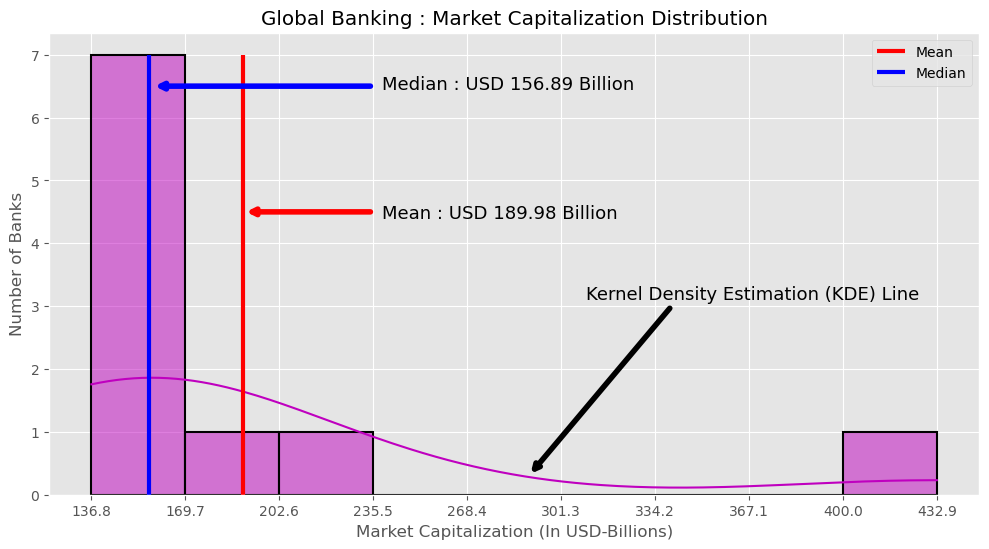

In [38]:
# Plotting a Histogram -- Market Capitalization (US$ Billion) --- Analyzing Distribution.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Getting evenly spaced bins and bars corresponding to the bins.
evenly_spaced = np.linspace(pandas_df["market_cap_in_usd_billion"].min(),pandas_df["market_cap_in_usd_billion"].max(), 10)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot Customization
plt.figure (figsize=(12,6))
sns.histplot(
        data = pandas_df,
        x ="market_cap_in_usd_billion",
        color = "m",
        edgecolor = "black",
        bins = evenly_spaced,
        lw = 1.5,
        kde = True
)

# Lines for Mean and Median
plt.vlines(x = pandas_df["market_cap_in_usd_billion"].mean(), ymin = 0, ymax = 7, colors = "red", label = "Mean", linewidth= 3)
plt.vlines(x = pandas_df["market_cap_in_usd_billion"].median(), ymin = 0, ymax = 7, colors = "blue", label = "Median", linewidth= 3)

# Labels
plt.title ("Global Banking : Market Capitalization Distribution")
plt.xlabel("Market Capitalization (In USD-Billions)")
plt.xticks(evenly_spaced)
plt.ylabel("Number of Banks")
plt.legend()

# Kernel Density (Arrow and Text Customization)
plt.annotate("", xy=(290, 0.3), xytext=(340, 3.0), arrowprops = dict(arrowstyle="->", connectionstyle="arc3", color="black", lw=4))
plt.text(310, 3.1, "Kernel Density Estimation (KDE) Line", fontsize=13)

# Median (Arrow and Text Customization)
plt.annotate("", xy=(158, 6.5), xytext=(235.5, 6.5), arrowprops = dict(arrowstyle="->", connectionstyle="arc3", color="blue", lw=4))
plt.text(238.5, 6.45, f'Median : USD {pandas_df["market_cap_in_usd_billion"].median():.2f} Billion', fontsize=13)

# Mean (Arrow and Text Customization)
plt.annotate("", xy=(190, 4.5), xytext=(235.5, 4.5), arrowprops = dict(arrowstyle="->", connectionstyle="arc3", color="red", lw=4))
plt.text(238.5, 4.4, f'Mean : USD {pandas_df["market_cap_in_usd_billion"].mean():.2f} Billion', fontsize=13)

# Plot the distribution of market cap
plt.show()

# Logging
log_progress ("Market Capitalization : Distribution Analysis using Histogram.")


#### **3.3. Bar Chart showing the Top 10 Banks by Market Cap**

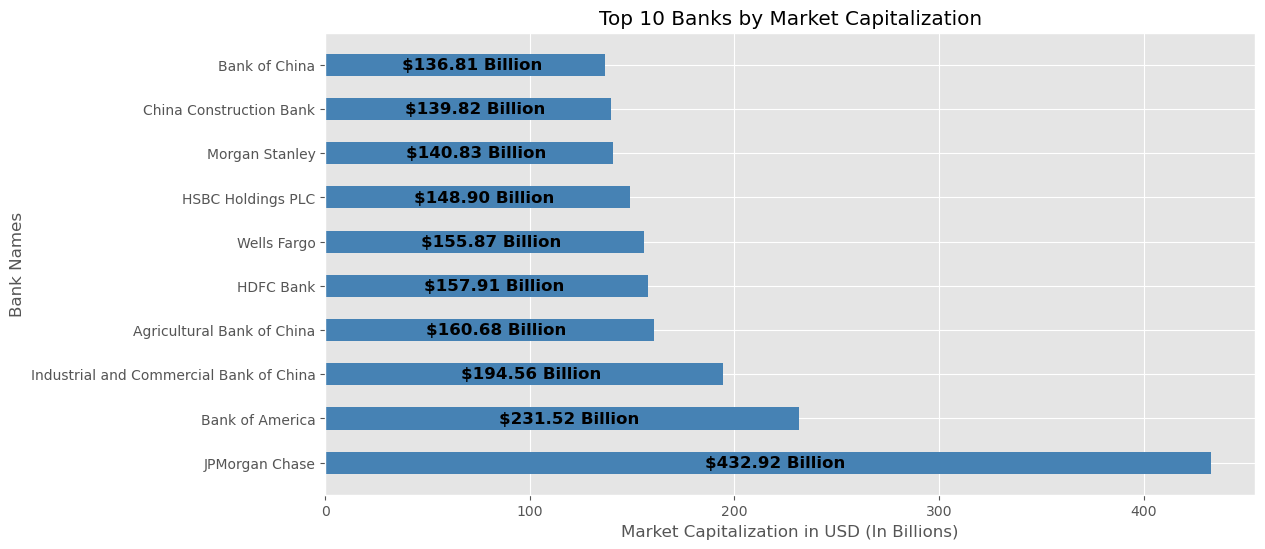

In [39]:
# Top 10 Banks by Market Cap -- Sort the DataFrame by market cap in descending order

top_ten_banks = pandas_df [["bank_name","market_cap_in_usd_billion"]].sort_values("market_cap_in_usd_billion", ascending=False).head(10).copy()
log_progress ("Temporary DataFrame created for analyzing Top 10 Banks.", "debug")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a bar chart for the Top 10 Banks by Market Cap
plt.figure (figsize=(12,6))
container_bars = plt.barh(
                        top_ten_banks["bank_name"], 
                        top_ten_banks["market_cap_in_usd_billion"],
                        height = 0.5,
                        color = "steelblue"
)
plt.title ("Top 10 Banks by Market Capitalization")
plt.xlabel("Market Capitalization in USD (In Billions)")
plt.ylabel("Bank Names")

# Customization : Labelling for Bars
plt.bar_label(container= container_bars, fmt= lambda x : f"${x:.2f} Billion", padding= 5, fontsize= 12, label_type= "center", fontweight = "bold")

# Plot the top 10 banks by market cap
plt.show()

# Logging
log_progress ("Market Capitalization : Top 10 Banks - Distribution Analysis using Bar Charts.")


#### **3.4. Relationship — Market Cap vs Bank Ranking** 

In [40]:
# Correlation Analysis.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print(pandas_df [["global_rank", "market_cap_in_usd_billion"]].corr())
print()
print(f"The Correlation Between Market Capitalization and Bank Ranking is : {(pandas_df[['global_rank', 'market_cap_in_usd_billion']].corr().iloc[0,1]):.2f}")
log_progress ("Correlation Analysis performed successfully between Market Capitalization and Bank Ranking.", "debug")


                           global_rank  market_cap_in_usd_billion
global_rank                   1.000000                  -0.734782
market_cap_in_usd_billion    -0.734782                   1.000000

The Correlation Between Market Capitalization and Bank Ranking is : -0.73


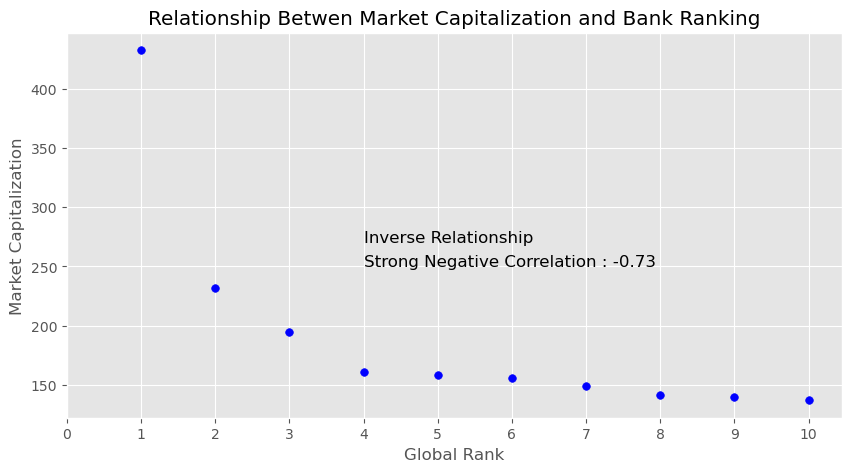

In [41]:
# Market Cap vs Rank
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot market cap vs rank
plt.figure (figsize= (10,5))
plt.scatter (
            data= pandas_df, 
            x = "global_rank", 
            y = "market_cap_in_usd_billion",
            s=30,
            marker= "o",
            c='b',
)
plt.title ("Relationship Betwen Market Capitalization and Bank Ranking")
plt.xlabel ("Global Rank")
plt.xticks (range(0,11))
plt.ylabel ("Market Capitalization")

# Text Customization
plt.text(4, 270, f"Inverse Relationship", fontsize=12)
plt.text(4, 250, f"Strong Negative Correlation : {(pandas_df[['global_rank', 'market_cap_in_usd_billion']].corr().iloc[0,1]):.2f}", fontsize=12)

# Plotting the scatter plot
plt.show ()

# Logging
log_progress ("Relationship between Market Capitalization and Bank Ranking.")


#### **3.5. Market Cap Analysis (Spread and Outliers)** 

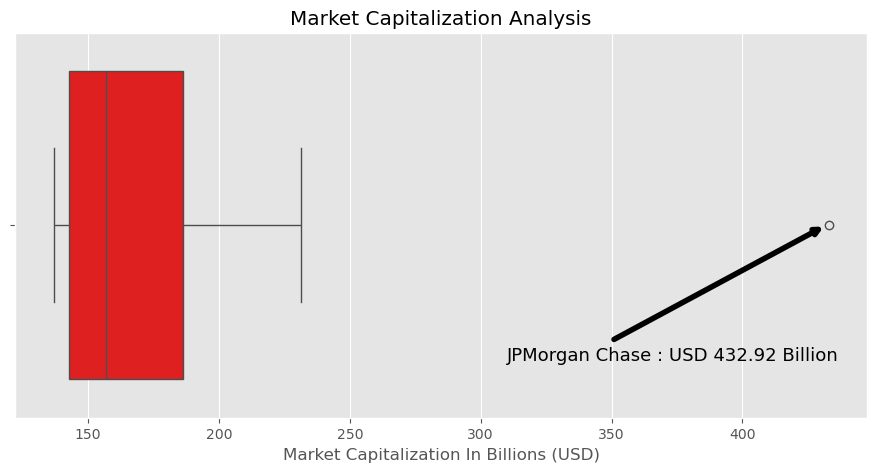

In [42]:
#To show the spread and outliers in the market capitalization data.
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Boxplot : Spread and Outliers in Market Capitalization

plt.figure (figsize= (11,5))
sns.boxplot (data = pandas_df, x= "market_cap_in_usd_billion", color= "red")
plt.title ("Market Capitalization Analysis")
plt.xlabel ("Market Capitalization In Billions (USD)")

# Potential Outlier (Arrow and Text Customization)
plt.annotate("", xy=(432,0), xytext=(350, 0.3), arrowprops = dict(arrowstyle="->", connectionstyle="arc3", color="black", lw=4))
plt.text(310, 0.35, f'{pandas_df.iloc [pandas_df["market_cap_in_usd_billion"].idxmax()]["bank_name"]} : USD {pandas_df["market_cap_in_usd_billion"].max():.2f} Billion', fontsize=13)

# Plot a boxplot of Market Capitalization
plt.show ()

# Logging
log_progress ("Market Capitalization Analysis using Box Plot for detecting Spread and Outliers.")


#### **3.6. Market Cap Quartile Distribution of Market Capitalization  Using a Violin Plot.** 

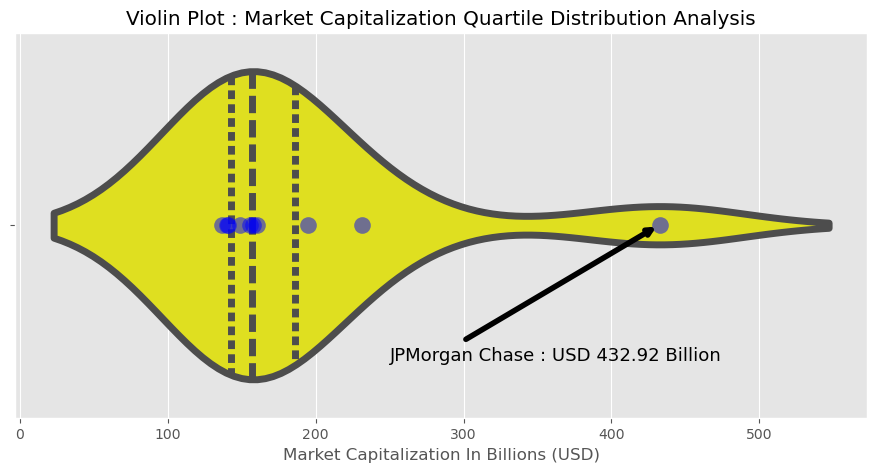

In [43]:
# Market Cap Distribution by Quartile
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Violin Plot of Market Cap

plt.figure (figsize= (11,5))
sns.violinplot(x= pandas_df["market_cap_in_usd_billion"], data= pandas_df, color="yellow", inner= "quartiles", linewidth= 5)
sns.stripplot(data= pandas_df, x= "market_cap_in_usd_billion", size=12, alpha= 0.5, jitter=False, color="blue")
plt.title ("Violin Plot : Market Capitalization Quartile Distribution Analysis")
plt.xlabel ("Market Capitalization In Billions (USD)")

# Potential Outlier (Arrow and Text Customization)
plt.annotate("", xy=(432,0), xytext=(300, 0.3), arrowprops = dict(arrowstyle="->", connectionstyle="arc3", color="black", lw=4))
plt.text(250, 0.35, f'{pandas_df.iloc [pandas_df["market_cap_in_usd_billion"].idxmax()]["bank_name"]} : USD {pandas_df["market_cap_in_usd_billion"].max():.2f} Billion', fontsize=13)

# Plot a violin plot of Market Capitalization
plt.show ()

# Logging
log_progress ("Market Capitalization Quartile Distribution using Violin Plot.")


#### **3.7. Cumulative Market Share Analysis** 

In [44]:
# Deriving Cumulative Market Share
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Cummulative Market Share DataFrame with necessary columns
cumulative_market_share_df = pandas_df [["bank_name","market_cap_in_usd_billion"]].sort_values("market_cap_in_usd_billion", ascending=False).copy()
log_progress ("Cumulative Market Share DataFrame has been created temporarily.", "debug")
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Deriving the cummulative market share column in our new dataframe
cumulative_market_share_df ["cumulative_market_share"] = (cumulative_market_share_df ["market_cap_in_usd_billion"].cumsum() / cumulative_market_share_df ["market_cap_in_usd_billion"].sum()) * 100

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Assigning the derived column to our original dataframe
pandas_df ["cumulative_market_share"] = cumulative_market_share_df ["cumulative_market_share"]

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("The First Ten Rows of Our Data Frame is as follows:\n")
log_progress ("Cumulative Market Share DataFrame has been created temporarily.", "debug")
pandas_df.head(10)



The First Ten Rows of Our Data Frame is as follows:



,global_rank,bank_name,market_cap_in_usd_billion,market_cap_in_eur_billion,market_cap_in_gbp_billion,market_cap_in_inr_billion,cumulative_market_share
0,1,JPMorgan Chase,432.92,402.62,346.34,35910.71,22.787422
1,2,Bank of America,231.52,215.31,185.22,19204.58,34.973840
2,3,Industrial and Commercial Bank of China,194.56,180.94,155.65,16138.75,45.214810
3,4,Agricultural Bank of China,160.68,149.43,128.54,13328.41,53.672453
4,5,HDFC Bank,157.91,146.86,126.33,13098.63,61.984293
5,6,Wells Fargo,155.87,144.96,124.70,12929.42,70.188755
6,7,HSBC Holdings PLC,148.90,138.48,119.12,12351.26,78.026339
7,8,Morgan Stanley,140.83,130.97,112.66,11681.85,85.439147
8,9,China Construction Bank,139.82,130.03,111.86,11598.07,92.798791
9,10,Bank of China,136.81,127.23,109.45,11348.39,100.000000


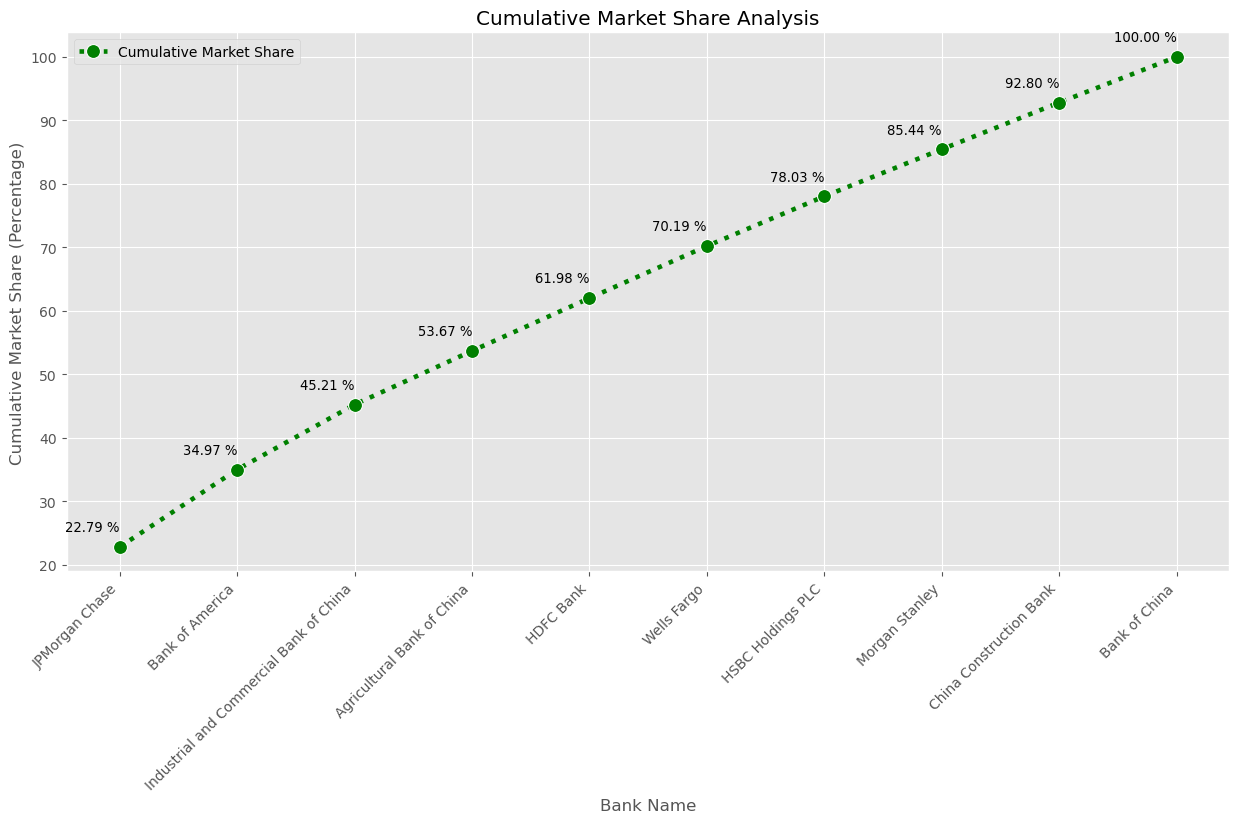

In [45]:
# Cumulative Market Share Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Let's plot a line plot

plt.figure (figsize=(15,7))
sns.lineplot (
            data= cumulative_market_share_df, 
            x = "bank_name", 
            y = "cumulative_market_share",
            marker = "o",
            markersize= 10,
            color= "green",
            linestyle="dotted",
            lw = 3.3
)
plt.title ("Cumulative Market Share Analysis")
plt.xlabel ("Bank Name")
plt.xticks(rotation = 45, ha = "right")
plt.ylabel ("Cumulative Market Share (Percentage)")
plt.legend (["Cumulative Market Share"])

# Setting the Text and Displaying the Plot
for a, b in zip (cumulative_market_share_df ["bank_name"], cumulative_market_share_df ["cumulative_market_share"]):
    plt.text(a, b + 2, f"{b:.2f} %", fontsize = 9.5, ha = "right", va = "bottom")

plt.show()

# Logging
log_progress ("Line Plot - Cumulative Market Share Analysis.")


#### **3.8. Categorising Banks — Grouping Banks by Market Cap Ranges and plot the Distribution** 

In [46]:
# Create market cap ranges
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Global Variable (This logic is scalable as it doesn't depend on fixed threshold. We create threshold as per our data.)
small, medium, large = np.linspace (pandas_df.market_cap_in_usd_billion.min(), pandas_df.market_cap_in_usd_billion.max(), 3)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Custom Function : Market Capitalization Tiers
def market_cap_tiers(market_cap_rows):
    
    if market_cap_rows <= small:
        return "Small-Cap"
    elif market_cap_rows <= medium:
        return "Mid-Cap"
    else:
        return "Large-Cap"
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Applying the function and deriving a distance tier feature

pandas_df ["market_cap_tiers"] = pandas_df.market_cap_in_usd_billion.apply(market_cap_tiers)

log_progress ("Market Cap Tiers function was defined and a new feature has been derived.", "debug")


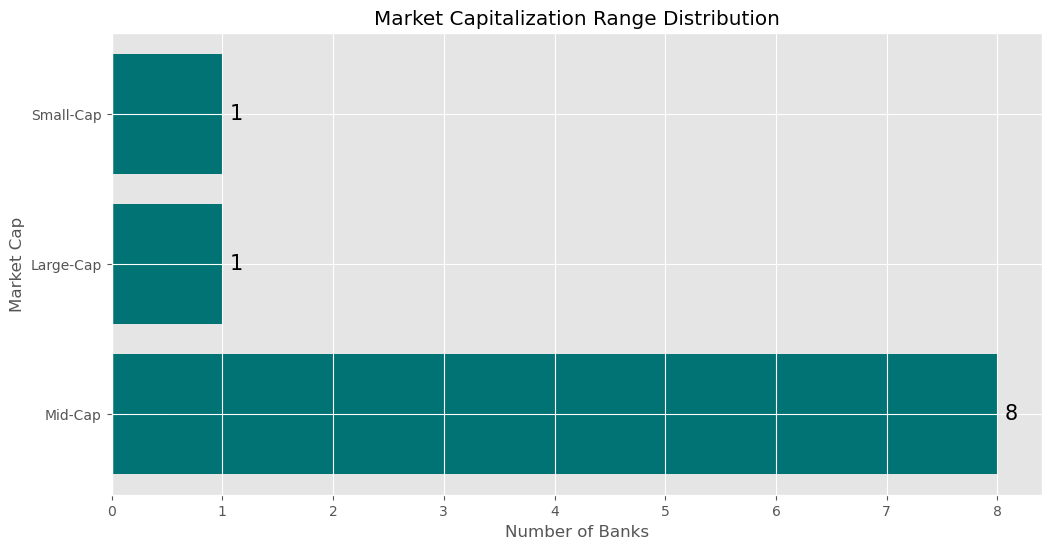

In [47]:
# Market Cap Range Distribution
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Series for Our Analysis
market_cap_bucket_series = pandas_df ["market_cap_tiers"].value_counts()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting Market Capitalization Distribution

plt.figure (figsize=(12,6))
container_bars = plt.barh(
                            market_cap_bucket_series.index, 
                            market_cap_bucket_series.values,
                            height = 0.8,
                            zorder = 0,
                            color = "xkcd:deep turquoise"
)
plt.title ("Market Capitalization Range Distribution")
plt.xlabel("Number of Banks")
plt.ylabel("Market Cap")
plt.ticklabel_format(style= "plain", axis="x")

# Customization : Labelling for Bars
plt.bar_label(container= container_bars, padding= 5, fontsize= 15)

# Plotting the Bar Chart
plt.show()

# Logging
log_progress ("Market Capitalization Range Distribution using Market Cap Tiers.")


#### **3.9. Visualizing Market Share Distribution using Pie Chart** 

In [48]:
# Custom : Market Share Percentage Calculation
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Total Market Capitalization Amount and Percentage
Total_Market_Cap_Amount = pandas_df ["market_cap_in_usd_billion"].sum().round(2).astype("float64")

for current_bankname, current_bank_marketcap in zip(pandas_df ["bank_name"], pandas_df ["market_cap_in_usd_billion"]):
   
    # Current Banks -- Market Share Percentage
    Current_Banks_Market_Cap_Percentage = np.round((current_bank_marketcap / Total_Market_Cap_Amount) * 100,2)

    print (f"Bank Name : {current_bankname} , Market Cap in (USD Billions) : $ {current_bank_marketcap:.2f} Billion , Market Share Percentage : {Current_Banks_Market_Cap_Percentage:.2f} %")
    print ()

log_progress ("Pie Charts can be misleading at times, Manual Percentage Distribution Calculations Completed.", "debug")


Bank Name : JPMorgan Chase , Market Cap in (USD Billions) : $ 432.92 Billion , Market Share Percentage : 22.79 %

Bank Name : Bank of America , Market Cap in (USD Billions) : $ 231.52 Billion , Market Share Percentage : 12.19 %

Bank Name : Industrial and Commercial Bank of China , Market Cap in (USD Billions) : $ 194.56 Billion , Market Share Percentage : 10.24 %

Bank Name : Agricultural Bank of China , Market Cap in (USD Billions) : $ 160.68 Billion , Market Share Percentage : 8.46 %

Bank Name : HDFC Bank , Market Cap in (USD Billions) : $ 157.91 Billion , Market Share Percentage : 8.31 %

Bank Name : Wells Fargo , Market Cap in (USD Billions) : $ 155.87 Billion , Market Share Percentage : 8.20 %

Bank Name : HSBC Holdings PLC , Market Cap in (USD Billions) : $ 148.90 Billion , Market Share Percentage : 7.84 %

Bank Name : Morgan Stanley , Market Cap in (USD Billions) : $ 140.83 Billion , Market Share Percentage : 7.41 %

Bank Name : China Construction Bank , Market Cap in (USD Bil

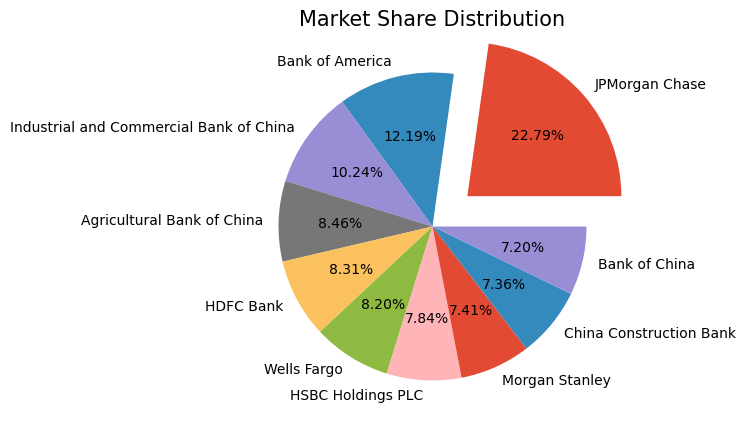

In [49]:
# Plot for Top 10 Banks Market Share (Pie-Chart)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Calculate market share percentage for top 10 banks
market_share_df = pandas_df[["bank_name","market_cap_in_usd_billion"]].sort_values("market_cap_in_usd_billion",ascending= False).head(10).copy()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting a Pie-Chart to analyze Market Share Distribution

plt.figure (figsize=(5,5))
plt.pie (pandas_df.market_cap_in_usd_billion, 
         labels = pandas_df.bank_name,
         autopct = '%.2f%%',
         explode = [0.3,0,0,0,0,0,0,0,0,0]
)
plt.title("Market Share Distribution", fontsize=15)
plt.show ()

log_progress ("Pie Chart - Market Share Percentage Distribution.")
log_progress ("Data Visualization ---> Completed Successfully.\n")


### **4. ETL and Querying**

In [50]:
# Logging 
log_progress ("Step 6 : ETL and Querying\n")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Let's View The Column Names (Sanity Check : If Renaming Required or Not)
print ("The Column Names of the PySpark DataFrame are as follows:\n")
for index, columns in enumerate (spark_df.columns):
    print (f"Column {index + 1}: {columns}")


The Column Names of the PySpark DataFrame are as follows:

Column 1: global_rank
Column 2: bank_name
Column 3: market_cap_in_usd_billion
Column 4: market_cap_in_eur_billion
Column 5: market_cap_in_gbp_billion
Column 6: market_cap_in_inr_billion


In [51]:
# Create window specifications (Dense Rank)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS windows_temp_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("windows_temp_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a column for Dense Rank
spark_df = spark.sql("""
                        SELECT *,
                        DENSE_RANK () OVER (ORDER BY `market_cap_in_usd_billion` DESC) AS `dense_rank`
                        FROM 
                        windows_temp_view
""")
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Caching the new DataFrame
spark_df.cache()

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Normalizing the cached DataFrame (Calling an action after Caching)
spark_df.show(truncate=True)
log_progress ("A new feature 'DENSE_RANK' has been derived successfully. The New DataFrame has been cached.", "debug")
log_progress ("Spark DataFrame has been cached and action has been called to allow smooth operations.", "debug")


+-----------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+----------+
|global_rank|           bank_name|market_cap_in_usd_billion|market_cap_in_eur_billion|market_cap_in_gbp_billion|market_cap_in_inr_billion|dense_rank|
+-----------+--------------------+-------------------------+-------------------------+-------------------------+-------------------------+----------+
|          1|      JPMorgan Chase|                   432.92|                   402.62|                   346.34|                 35910.71|         1|
|          2|     Bank of America|                   231.52|                   215.31|                   185.22|                 19204.58|         2|
|          3|Industrial and Co...|                   194.56|                   180.94|                   155.65|                 16138.75|         3|
|          4|Agricultural Bank...|                   160.68|                   149.43|              

In [52]:
# Cross-Currency ETL Querying 
# This will enable the user to use Cross-Currency Analysis
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Defining Variables for Cross-Currency Evaluation (Loop)

keep_executing = True
currency_list = ["USD", "EUR", "GBP", "INR"]
currency_dict = {
                "USD" : "market_cap_in_usd_billion", 
                "EUR" : "market_cap_in_eur_billion", 
                "GBP" : "market_cap_in_gbp_billion", 
                "INR" : "market_cap_in_inr_billion"
}
log_progress ("The User has been prompted to choose a currency for further analysis.", "debug")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Cross Currency --- Choosing the Currency

while keep_executing:
    print ('Currencies : ["USD", "EUR", "GBP", "INR"]\n')
    currency = input("Which Currency would you like to perform the further Analysis on?\n").strip().upper()

    if currency in currency_list:
        print (f"\nYou have chosen {currency}, All the further ETL querying will happen in {currency}.\n")
        currency_col = currency_dict.get(currency)
        break
    else:
        print (f"Please try again with the available options : {currency_list}\n")
        continue

log_progress (f"The User has chosen {currency} for further ETL querying and Dashboard.")


Currencies : ["USD", "EUR", "GBP", "INR"]



Which Currency would you like to perform the further Analysis on?
 usd



You have chosen USD, All the further ETL querying will happen in USD.



#### **4.1. Advanced Market Capitalization Analysis with Growth Metrics** 

In [53]:
# Query: Advanced Market Cap Analysis with Growth Metrics
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS advanced_market_growth_view")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("advanced_market_growth_view")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
sql_query_1 = f"""
                WITH CUMMULATIVE_SHARE_CTE AS
                            (SELECT 
                                dense_rank, global_rank, bank_name, {currency_col},
                                ROUND({currency_col} / (SELECT SUM({currency_col}) FROM advanced_market_growth_view) * 100, 2) 
                                    AS 
                                MARKET_SHARE
                            FROM 
                                advanced_market_growth_view
                            ORDER BY
                                MARKET_SHARE DESC),

                MARKET_DOMINANCE_CTE AS
                            (SELECT *,
                                ROUND(SUM({currency_col}) OVER (ORDER BY {currency_col} DESC), 2) 
                                                                                    AS CUMMULATIVE_MARKET_CAP,
                                                                                                        
                                ROUND(SUM(MARKET_SHARE) OVER (ORDER BY MARKET_SHARE DESC), 2) 
                                                                                    AS CUMMULATIVE_MARKET_SHARE,
                                                                                    
                                ROUND ({currency_col} - (SELECT MAX({currency_col}) FROM advanced_market_growth_view), 2)
                                                                                                                AS GAP_FROM_LEADING_BANK,

                                ROUND((({currency_col} - 
                                        (SELECT AVG({currency_col}) FROM advanced_market_growth_view)) / 
                                                    (SELECT AVG({currency_col}) FROM advanced_market_growth_view)) * 100, 2) AS GROWTH_RATE
                                                    
                            FROM
                                CUMMULATIVE_SHARE_CTE)
                                
                SELECT
                
                dense_rank AS DENSE_RANK,
                
                global_rank AS GLOBAL_RANK,
                
                bank_name AS BANK_NAME,
                
                CONCAT ({currency_col}, ' Billion {currency}') AS MARKET_CAPITAL,
                
                MARKET_SHARE, CUMMULATIVE_MARKET_CAP, CUMMULATIVE_MARKET_SHARE, GAP_FROM_LEADING_BANK, GROWTH_RATE
                
                    FROM 
                        MARKET_DOMINANCE_CTE"""
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print (f"Advanced Market Capitalization Analysis with Growth Metrics :-\n")
advanced_market_cap_query = spark.sql(sql_query_1)
advanced_market_cap_query.show(truncate=False)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Convert to Pandas DataFrame for Dash-Board
advanced_market_cap_df = advanced_market_cap_query.toPandas()

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Advanced Market Capitalization Analysis with Growth Metrics Successful.")


Advanced Market Capitalization Analysis with Growth Metrics :-

+----------+-----------+---------------------------------------+------------------+------------+----------------------+------------------------+---------------------+-----------+
|DENSE_RANK|GLOBAL_RANK|BANK_NAME                              |MARKET_CAPITAL    |MARKET_SHARE|CUMMULATIVE_MARKET_CAP|CUMMULATIVE_MARKET_SHARE|GAP_FROM_LEADING_BANK|GROWTH_RATE|
+----------+-----------+---------------------------------------+------------------+------------+----------------------+------------------------+---------------------+-----------+
|1         |1          |JPMorgan Chase                         |432.92 Billion USD|22.79       |432.92                |22.79                   |0.0                  |127.87     |
|2         |2          |Bank of America                        |231.52 Billion USD|12.19       |664.44                |34.98                   |-201.4               |21.86      |
|3         |3          |Industrial and Co

#### **4.2.Market Concentration Analysis [Based on Market Share Tiers]** 

##### **Herfindahl–Hirschman Index (HHI) Formula**
- It is a common measure for market concentration.
- It is used to calculate/determine the amount of competitiveness.

$$
\text{HHI} \;=\; \sum_{i=1}^{N} s_i^{2}
\qquad\text{(each } s_i \text{ is a percentage; HHI range: 0–10{,}000)}
$$

In [54]:
# Market Concentration Analysis
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS market_concentration_view")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("market_concentration_view")

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sql_query_1 = f"""
                SELECT 
                    COUNT(DISTINCT(bank_name)) AS NUMBER_OF_BANKS,
                    CONCAT(ROUND(SUM({currency_col}), 2), ' Billion {currency}') AS TOTAL_MARKET_CAP
                FROM
                    market_concentration_view
"""
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
common_table_exp = f"""
                        SELECT
                            bank_name,
                            ROUND(
                                ({currency_col} / (SELECT SUM ({currency_col}) 
                                                                FROM market_concentration_view) * 100), 2)
                            AS INDIVIDUAL_MARKET_CAP
                        FROM
                            market_concentration_view
"""
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sql_query_2 = f"""
                WITH 
                    MARKET_CONCENTRATION_CTE AS ({common_table_exp})
                SELECT
                    bank_name AS `BANK NAME`, 
                    CONCAT (CAST(INDIVIDUAL_MARKET_CAP AS STRING), ' %') AS INDIVIDUAL_MARKET_CAP_PERCENTAGE,
                    CASE
                        WHEN 
                            INDIVIDUAL_MARKET_CAP <= (PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER())
                        THEN 
                            'EMERGING PLAYERS'
                        WHEN 
                                (INDIVIDUAL_MARKET_CAP > (PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER()))                        
                            AND
                                (INDIVIDUAL_MARKET_CAP <= (PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER()))
                        THEN 
                            'MID LEVEL PLAYERS'    
                        WHEN 
                                (INDIVIDUAL_MARKET_CAP > (PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER()))                        
                            AND
                                (INDIVIDUAL_MARKET_CAP <= (PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER()))
                        THEN 
                            'STRONG PERFORMERS'
                        ELSE
                            'MARKET LEADERS'
                    END AS
                        MARKET_CONCENTRATION_TIERS
                    FROM
                       MARKET_CONCENTRATION_CTE 
                    ORDER BY
                        INDIVIDUAL_MARKET_CAP DESC
"""
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sql_query_3 = f"""
                WITH 
                    MARKET_CONCENTRATION_CTE AS ({common_table_exp})
                SELECT *,
                    ROUND(PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER(), 2) AS `Q1`,
                    ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER(), 2) AS `Q2`,
                    ROUND(PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY INDIVIDUAL_MARKET_CAP) OVER(), 2) AS `Q3`
                FROM
                    MARKET_CONCENTRATION_CTE
                LIMIT 1"""

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a detailed summary table on market concentration
sql_query_4 = f"""
                 WITH 
                    NEW_MARKET_CONCENTRATION_CTE AS 
                                            ({sql_query_2}),
                    ADVANCED_MARKET_CTE AS
                                            ({sql_query_3})
                SELECT
                    COUNT (`BANK NAME`) AS `NUMBER OF BANKS`,
                    CONCAT_WS (", " , COLLECT_LIST(`BANK NAME`)) AS `NAMES OF BANKS`,
                    MARKET_CONCENTRATION_TIERS,
                    CASE
                        WHEN MARKET_CONCENTRATION_TIERS = 'MARKET LEADERS' THEN CONCAT ('> ', ANY_VALUE(Q3), '%')
                        WHEN MARKET_CONCENTRATION_TIERS = 'STRONG PERFORMERS' THEN CONCAT (ANY_VALUE(Q2),'%', ' - ', ANY_VALUE(Q3), '%')
                        WHEN MARKET_CONCENTRATION_TIERS = 'MID LEVEL PLAYERS' THEN CONCAT (ANY_VALUE(Q1),'%', ' - ', ANY_VALUE(Q2), '%')
                        WHEN MARKET_CONCENTRATION_TIERS = 'EMERGING PLAYERS' THEN CONCAT ('< ', ANY_VALUE(Q1), '%')
                    END AS
                        `THRESHOLD`
                FROM
                    NEW_MARKET_CONCENTRATION_CTE
                    CROSS JOIN
                    ADVANCED_MARKET_CTE
                GROUP BY
                    MARKET_CONCENTRATION_TIERS"""

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# HHI Analysis : Used to measure competitiveness and how concentrated the market is.
# This Kind of Analysis will tell us how close a market is to a monopoly.
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# HHI is usually represent on a scale of zero to ten thousand.
HHI_Scale = 10_000

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# HHI Analysis -- To Analyze Advanced Market Concentration
sql_query_5 = f"""
                WITH 
                    MARKET_CONCENTRATION_CTE AS ({common_table_exp}),
                
                HHI_CTE AS
                        (SELECT
                            ROUND (SUM (POW (INDIVIDUAL_MARKET_CAP / 100, 2)), 4) * {HHI_Scale} AS HHI_SCORE
                        FROM
                            MARKET_CONCENTRATION_CTE)
                SELECT 
                     HHI_SCORE,
                     CASE
                         WHEN HHI_SCORE = 10000 THEN "MONOPOLY"
                         WHEN HHI_SCORE >= 2500 THEN "HIGHLY CONCENTRATED MARKET"
                         WHEN HHI_SCORE >= 1500 THEN "MODERATELY CONCENTRATED MARKET"
                         ELSE "LOW CONCENTRATION - HIGHLY COMPETITIVE MARKET"
                     END AS
                         HHI_SCORE_INTERPRETATION
                FROM
                    HHI_CTE
                    """
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("Let's view the total number of banks and their collective market capital:-\n")
spark.sql(sql_query_1).show(truncate=False)

print ("Let's view the banks individual market cap and their concentration tier:-\n")
spark.sql(sql_query_2).show(truncate=False)

print ("Summary Table for Market Concentration Analysis and Threshold based on statistics:-\n")
spark.sql(sql_query_4).show(truncate=False)

print ("HHI Concentration Score to analyze how concentrated the market is:-\n")
hhi_score = spark.sql(sql_query_5)
hhi_score.show(truncate=False)

hhi_score_df = hhi_score.toPandas()

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Market Concentration Analysis based on Market Share Tiers Successful.")


Let's view the total number of banks and their collective market capital:-

+---------------+-------------------+
|NUMBER_OF_BANKS|TOTAL_MARKET_CAP   |
+---------------+-------------------+
|10             |1899.82 Billion USD|
+---------------+-------------------+

Let's view the banks individual market cap and their concentration tier:-

+---------------------------------------+--------------------------------+--------------------------+
|BANK NAME                              |INDIVIDUAL_MARKET_CAP_PERCENTAGE|MARKET_CONCENTRATION_TIERS|
+---------------------------------------+--------------------------------+--------------------------+
|JPMorgan Chase                         |22.79 %                         |MARKET LEADERS            |
|Bank of America                        |12.19 %                         |MARKET LEADERS            |
|Industrial and Commercial Bank of China|10.24 %                         |MARKET LEADERS            |
|Agricultural Bank of China             |8.46 

#### **4.3. Market Capitalization Statistical Distribution Using Quartile Analysis**

In [55]:
# Query 3: Statistical Distribution Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS statistical_distribution_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("statistical_distribution_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : Total Number of Banks, The Lowest Market Capitalization and The Highest Market Capitalization
sql_query_1 = f"""
                    SELECT
                        CONCAT(MIN({currency_col}), ' Billion {currency}') AS `MINIMUM_MARKET_CAP`,
                        CONCAT(MAX({currency_col}), ' Billion {currency}') AS `MAXIMUM_MARKET_CAP`,
                        COUNT (DISTINCT (bank_name)) AS `NUMBER_OF_BANKS`
                    FROM
                        statistical_distribution_view
"""

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : Quartile Analysis to understand the Statistical Distribution
sql_query_2 = f"""
                WITH QUARTILE_CTE AS
                    (SELECT 
                        ROUND (PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY {currency_col}) OVER(), 2) AS `QUARTILE_1 (Q1)`,
                        ROUND (PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY {currency_col}) OVER(), 2) AS `MEDIAN_QUARTILE_2 (Q2)`,
                        ROUND (PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY {currency_col}) OVER(), 2) AS `QUARTILE_3 (Q3)`
                    FROM
                        statistical_distribution_view
                    LIMIT 1),
                    
                ADVANCED_QUARTILE_CTE AS
                    (SELECT
                        *,
                        ROUND(`QUARTILE_3 (Q3)` - `QUARTILE_1 (Q1)`, 2) AS `INTERQUARTILE_RANGE (IQR)`
                    FROM
                        QUARTILE_CTE)
                        
                SELECT
                    SDV.bank_name, 
                    CONCAT(AQC.`QUARTILE_1 (Q1)`, ' Billion {currency}') AS `QUARTILE_1 (Q1)`, 
                    CONCAT(AQC.`MEDIAN_QUARTILE_2 (Q2)`, ' Billion {currency}') AS `MEDIAN_QUARTILE_2 (Q2)`, 
                    CONCAT(AQC.`QUARTILE_3 (Q3)`, ' Billion {currency}') AS `QUARTILE_3 (Q3)`, 
                    CONCAT(AQC.`INTERQUARTILE_RANGE (IQR)`, ' Billion {currency}') AS `INTERQUARTILE_RANGE (IQR)`,
                    CASE
                        WHEN SDV.{currency_col} <= AQC.`QUARTILE_1 (Q1)` THEN "FIRST_QUARTILE"
                        WHEN (SDV.{currency_col} > AQC.`QUARTILE_1 (Q1)`) AND (SDV.{currency_col} <= AQC.`MEDIAN_QUARTILE_2 (Q2)`) THEN "SECOND_QUARTILE"
                        WHEN (SDV.{currency_col} > AQC.`MEDIAN_QUARTILE_2 (Q2)`) AND (SDV.{currency_col} <= AQC.`QUARTILE_3 (Q3)`) THEN "THIRD_QUARTILE"
                        ELSE "FOURTH_QUARTILE"
                    END AS
                        QUARTILE_CATEGORIES
                    FROM
                ADVANCED_QUARTILE_CTE 
                                    AS AQC
                CROSS JOIN
                    statistical_distribution_view 
                                                AS SDV       
"""
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#  Query : Bank with the Least Market Capitalization
sql_query_3 = f"""
                SELECT 
                    bank_name AS BANK_NAME,
                    CONCAT ({currency_col}, ' Billion {currency}') AS MINIMUM_MARKET_CAP
                FROM
                    statistical_distribution_view
                WHERE
                    {currency_col} IN (SELECT MIN ({currency_col}) AS `MINIMUM` FROM statistical_distribution_view)
"""

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : Bank with the Highest Market Capitalization
sql_query_4 = f"""
                SELECT 
                    bank_name AS BANK_NAME, 
                    CONCAT ({currency_col}, ' Billion {currency}') AS MAXIMUM_MARKET_CAP
                FROM
                    statistical_distribution_view
                WHERE
                {currency_col} IN (SELECT MAX ({currency_col}) AS `MAXIMUM` FROM statistical_distribution_view)
"""


# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print (f"The Total Number of Banks, The Lowest Market Capitalization and The Highest Market Capitalization :-\n")
spark.sql(sql_query_1).select("NUMBER_OF_BANKS", "MINIMUM_MARKET_CAP", "MAXIMUM_MARKET_CAP").show()

print (f"The Quartile Analysis of Market Capitalization is as follows :-\n")
spark.sql(sql_query_2).select("QUARTILE_1 (Q1)","MEDIAN_QUARTILE_2 (Q2)","QUARTILE_3 (Q3)", "INTERQUARTILE_RANGE (IQR)").show(1)
spark.sql(sql_query_2).select("bank_name","QUARTILE_CATEGORIES").show(truncate=False)

print (f"The Bank with the Least Market Capitalization is :-\n")
spark.sql(sql_query_3).show()

print (f"The Bank with the Highest Market Capitalization is :-\n")
spark.sql(sql_query_4).show()

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Statistical Distribution : Market Capitalization Distribution using Quartile Analysis Successful.")


The Total Number of Banks, The Lowest Market Capitalization and The Highest Market Capitalization :-

+---------------+------------------+------------------+
|NUMBER_OF_BANKS|MINIMUM_MARKET_CAP|MAXIMUM_MARKET_CAP|
+---------------+------------------+------------------+
|             10|136.81 Billion USD|432.92 Billion USD|
+---------------+------------------+------------------+

The Quartile Analysis of Market Capitalization is as follows :-

+------------------+----------------------+------------------+-------------------------+
|   QUARTILE_1 (Q1)|MEDIAN_QUARTILE_2 (Q2)|   QUARTILE_3 (Q3)|INTERQUARTILE_RANGE (IQR)|
+------------------+----------------------+------------------+-------------------------+
|142.85 Billion USD|    156.89 Billion USD|186.09 Billion USD|        43.24 Billion USD|
+------------------+----------------------+------------------+-------------------------+
only showing top 1 row

+---------------------------------------+-------------------+
|bank_name           

#### **4.4. Comparative Size Analysis [Classifying Banks by Relative Market Size]** 

In [56]:
# Comparative Size Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS comparative_size_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("comparative_size_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Comparative Size Analysis (Comparing to Leading Bank and Comparing to Average)

compare_to_leading_bank = f"SELECT MAX({currency_col}) FROM comparative_size_view"
compare_to_average = f"SELECT AVG({currency_col}) FROM comparative_size_view"
compare_to_median = f"SELECT MEDIAN({currency_col}) FROM comparative_size_view"
compare_to_total = f"SELECT SUM({currency_col}) FROM comparative_size_view"
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# SQL Query using PySpark for Classifying banks based of their Market Capitalization into Tier's of Relative Market Size 
# Performing a detailed Comparative Size Analysis

for sub_query in [compare_to_leading_bank, compare_to_average, compare_to_median, compare_to_total]:

    sql_query_1 = f"""
                    WITH comparative_size_cte AS
                        (SELECT 
                            global_rank, bank_name,
                            ROUND({currency_col} / ({sub_query}) * 100, 2) 
                                AS 
                            RELATIVE_MARKET_SHARE
                                FROM 
                            comparative_size_view)
                         
                         SELECT *,
                            PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY RELATIVE_MARKET_SHARE) OVER() AS `TIER_1`,
                            PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY RELATIVE_MARKET_SHARE) OVER() AS `TIER_3`,
                             CASE 
                                 WHEN RELATIVE_MARKET_SHARE <= TIER_1 
                                                         THEN "SMALL-SIZE"
                                 WHEN RELATIVE_MARKET_SHARE <= TIER_3
                                                         THEN "MEDIUM-SIZE"
                                 ELSE "LARGE-SIZE"
                             END AS 
                                 `RELATIVE_SIZE`
                         FROM
                             comparative_size_cte
                         ORDER BY
                             RELATIVE_MARKET_SHARE DESC
"""
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # This logic is inside the "FOR LOOP" to compute and display the tables.
    
    if compare_to_leading_bank == sub_query:
        print (f"The Comparative Size Analysis: Compared to the Leading Bank Market Capitalization:-\n")
        spark.sql(sql_query_1).select("global_rank","bank_name", "RELATIVE_MARKET_SHARE", "RELATIVE_SIZE").show(10, truncate=False)
    
    elif compare_to_average == sub_query:
        print (f"The Comparative Size Analysis: Compared to the Average Market Capitalization:-\n")
        spark.sql(sql_query_1).select("global_rank","bank_name", "RELATIVE_MARKET_SHARE", "RELATIVE_SIZE").show(10, truncate=False)

    elif compare_to_median == sub_query:
        print (f"The Comparative Size Analysis: Compared to the Median Market Capitalization:-\n")
        spark.sql(sql_query_1).select("global_rank","bank_name", "RELATIVE_MARKET_SHARE", "RELATIVE_SIZE").show(10, truncate=False)

    else:
        print (f"The Comparative Size Analysis: Compared to the Total Market Capitalization:-\n")
        spark.sql(sql_query_1).select("global_rank","bank_name", "RELATIVE_MARKET_SHARE", "RELATIVE_SIZE").show(10, truncate=False)
        
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Comparative Size Analysis based on Relative Market Size Successful.")


The Comparative Size Analysis: Compared to the Leading Bank Market Capitalization:-

+-----------+---------------------------------------+---------------------+-------------+
|global_rank|bank_name                              |RELATIVE_MARKET_SHARE|RELATIVE_SIZE|
+-----------+---------------------------------------+---------------------+-------------+
|1          |JPMorgan Chase                         |100.0                |LARGE-SIZE   |
|2          |Bank of America                        |53.48                |LARGE-SIZE   |
|3          |Industrial and Commercial Bank of China|44.94                |LARGE-SIZE   |
|4          |Agricultural Bank of China             |37.12                |MEDIUM-SIZE  |
|5          |HDFC Bank                              |36.48                |MEDIUM-SIZE  |
|6          |Wells Fargo                            |36.0                 |MEDIUM-SIZE  |
|7          |HSBC Holdings PLC                      |34.39                |MEDIUM-SIZE  |
|8          |Mo

#### **4.5. Market Growth Analysis [On basis of Gaps Between Consecutive Banks]**

<div style="text-align: center; font-weight: bold;">
Gap To Next = Current Bank Market Cap - Next Bank Market Cap
</div>

- `Higher Gap to Next` represents the bank has a massive lead compared to the next bank.
- `Lower Gap to Next` represents highly competitive, banks have almost the same market capitalization.

$$
\textbf{Gap\ Percentage} = \left( \frac{\mathbf{Current\ Bank\ Market\ Cap} - \mathbf{Next\ Bank\ Market\ Cap}}{\mathbf{Current\ Bank\ Market\ Cap}} \right) \times \mathbf{100}
$$

- `Higher Gap Percentage` represents Strong Dominance.
- `Lower Gap Percentage` represents Tight Competition.

$$
\textbf{Growth\ Rate}_i = \left( \frac{Market\ Cap_i - Average\ Market\ Cap}{Average\ Market\ Cap} \right) \times 100
$$

- `Growth Rate > 0` represents leading banks. Bank's market capitalization is above market average.
- `Growth Rate < 0` represents bank is below average, indicating weaker presence.

<div style="text-align: center; font-weight: bold;">
Outperformance Rate = Gap Percentage - Average (Gap Percentage)
</div>

- `Outperformance Rate > 0` represents bank is outperforming the market average.
- `Outperformance Rate < 0` represents bank is underperforming relative to other banks.

$$
\textbf{Gap\ Velocity}_i = \frac{ GAP\_TO\_NEXT }{ \max(GAP\_TO\_NEXT) } \times 100
$$

- If `Gap Velocity = 100`, it represents absolute dominance. (Biggest Gap)
- If `Gap Velocity ≈ 0`, it represents tight competition. (Smallest Gap)

In [57]:
# Growth and Gap Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS market_growth_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("market_growth_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Sum of Market Expansion Weights will be 1
# This metric is used to track the company's growth.

market_expansion_weight_1 = 0.50  # Represents Structured Growth
market_expansion_weight_2 = 0.33  # Competitive Growth
market_expansion_weight_3 = 0.17  # Gap Velocity Weight

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sql_query_1 = f"""
                WITH GROWTH_GAP_CTE
                (SELECT global_rank, bank_name, {currency_col},
                    ROUND ({currency_col} - LEAD({currency_col}, 1) OVER (ORDER BY dense_rank), 2) AS GAP_TO_NEXT,
                    ROUND ((({currency_col} - LEAD({currency_col}, 1) OVER (ORDER BY dense_rank)) / {currency_col}) * 100, 2) AS GAP_PERCENTAGE,
                    ROUND((({currency_col} - 
                                (SELECT AVG({currency_col}) FROM market_growth_view)) / 
                                                    (SELECT AVG({currency_col}) FROM market_growth_view)) * 100, 2) AS GROWTH_RATE
                FROM
                    market_growth_view
                ORDER BY
                    {currency_col} DESC),

                MARKET_EXPANSION_CTE AS
                (SELECT
                    *,
                    ROUND (GAP_PERCENTAGE - (SELECT AVG(GAP_PERCENTAGE) FROM GROWTH_GAP_CTE), 2) AS OUTPERFORMANCE_RATE,
                    ROUND ((GAP_TO_NEXT / (SELECT MAX(GAP_TO_NEXT) FROM GROWTH_GAP_CTE) * 100), 2) AS GAP_VELOCITY
                FROM
                    GROWTH_GAP_CTE
                WHERE
                    (GAP_TO_NEXT IS NOT NULL) OR (GAP_PERCENTAGE IS NOT NULL))

                SELECT
                    global_rank AS GLOBAL_RANK,
                    
                    bank_name AS BANK_NAME,
                    
                    CONCAT({currency_col}, ' Billion {currency}') AS MARKET_CAPITAL,
                    
                    GAP_TO_NEXT, GAP_PERCENTAGE, GROWTH_RATE, OUTPERFORMANCE_RATE, GAP_VELOCITY,
                    
                    (ROUND(GROWTH_RATE * {market_expansion_weight_1} +
                                OUTPERFORMANCE_RATE * {market_expansion_weight_2} +
                                                    GAP_VELOCITY * {market_expansion_weight_3}, 2)) AS MARKET_EXPANSION_INDEX
                                                                                                FROM
                                                                                                    MARKET_EXPANSION_CTE
                """
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("Market Growth and Gap Analysis is as follows:-\n")
market_growth_analysis = spark.sql(sql_query_1)
market_growth_analysis.show(truncate=False)

# Convert to Pandas for Dashboard
market_growth_analysis_df = market_growth_analysis.toPandas()
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Market Growth and Gap Analysis Successful.")        


Market Growth and Gap Analysis is as follows:-

+-----------+---------------------------------------+------------------+-----------+--------------+-----------+-------------------+------------+----------------------+
|GLOBAL_RANK|BANK_NAME                              |MARKET_CAPITAL    |GAP_TO_NEXT|GAP_PERCENTAGE|GROWTH_RATE|OUTPERFORMANCE_RATE|GAP_VELOCITY|MARKET_EXPANSION_INDEX|
+-----------+---------------------------------------+------------------+-----------+--------------+-----------+-------------------+------------+----------------------+
|1          |JPMorgan Chase                         |432.92 Billion USD|201.4      |46.52         |127.87     |35.89              |100.0       |92.78                 |
|2          |Bank of America                        |231.52 Billion USD|36.96      |15.96         |21.86      |5.33               |18.35       |15.81                 |
|3          |Industrial and Commercial Bank of China|194.56 Billion USD|33.88      |17.41         |2.41       |6

#### **4.6. Market Dominance Analysis [Individual and Cumulative Dominance Score]** 


$$ \mathrm{IndividualDominanceScore}_i = \mathrm{BaseLine} + \mathrm{Scale} \times \frac{(\mathrm{ActualShare}_i - \mathrm{FairShare})}{(\mathrm{MaxPossibleShare} - \mathrm{FairShare})}= 5 + 5 \times \frac{\left( \mathrm{ActualShare}_i - \frac{\mathrm{MaxPossibleShare}}{N} \right)}{\left( \mathrm{MaxPossibleShare} - \frac{\mathrm{MaxPossibleShare}}{N} \right)} $$

- **`Actual Share`** refers to the banks market share percentage.
- **`N`** refers to the Total Number of Banks.

In [58]:
# Market Dominance Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS market_dominance_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("market_dominance_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Represents the Central Point of Fairness (Neutral Point)
base_line = 5

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# The Individual Dominance Score - Can extend by the Scale that is 5 on each side (0-10)
scale = 5

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : Individual Dominance Score

sql_query_1 = f"""
                WITH CUMMULATIVE_SHARE_CTE AS
                            (SELECT 
                                global_rank, bank_name,
                                ROUND({currency_col} / ({compare_to_total}) * 100, 2) 
                                    AS 
                                MARKET_SHARE
                            FROM 
                                comparative_size_view
                            ORDER BY
                                MARKET_SHARE DESC),

                MARKET_DOMINANCE_CTE AS
                            (SELECT *,
                                SUM(MARKET_SHARE) OVER (ORDER BY MARKET_SHARE DESC) AS CUMMULATIVE_MARKET_SHARE,
                                global_rank * (100/(SELECT COUNT (DISTINCT(bank_name)) FROM CUMMULATIVE_SHARE_CTE)) AS  EXPECTED_CUMMULATIVE 
                            FROM
                                CUMMULATIVE_SHARE_CTE),

                MAX_POSSIBLE_SHARE_CTE AS
                            (SELECT *,
                                
                                (SELECT 
                                    MAX(CUMMULATIVE_MARKET_SHARE)
                                FROM
                                    MARKET_DOMINANCE_CTE) AS MAX_POSSIBLE_SHARE,
                                
                                (SELECT 
                                    COUNT(bank_name)
                                FROM
                                    MARKET_DOMINANCE_CTE) AS NUMBER_OF_BANKS
                                    
                             FROM
                                MARKET_DOMINANCE_CTE )

                SELECT *,
                      ROUND((
                       ({base_line} + {scale} * (MARKET_SHARE - (MAX_POSSIBLE_SHARE / NUMBER_OF_BANKS)) /
                        (MAX_POSSIBLE_SHARE - (MAX_POSSIBLE_SHARE / NUMBER_OF_BANKS)))
                                ), 2)
                AS 
                    INDIVIDUAL_DOMINANCE_SCORE     
                FROM
                    MAX_POSSIBLE_SHARE_CTE
"""
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print ("Cummulative Market Share and Individual Dominance Score is as follows:-\n")
spark.sql (sql_query_1).select("global_rank", "bank_name", "MARKET_SHARE", "CUMMULATIVE_MARKET_SHARE", "INDIVIDUAL_DOMINANCE_SCORE").show(truncate=False)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Market Dominance Analysis - Cumulative Market Share and Individual Dominance Score Successful.")  


Cummulative Market Share and Individual Dominance Score is as follows:-

+-----------+---------------------------------------+------------+------------------------+--------------------------+
|global_rank|bank_name                              |MARKET_SHARE|CUMMULATIVE_MARKET_SHARE|INDIVIDUAL_DOMINANCE_SCORE|
+-----------+---------------------------------------+------------+------------------------+--------------------------+
|1          |JPMorgan Chase                         |22.79       |22.79                   |5.71                      |
|2          |Bank of America                        |12.19       |34.98                   |5.12                      |
|3          |Industrial and Commercial Bank of China|10.24       |45.22                   |5.01                      |
|4          |Agricultural Bank of China             |8.46        |53.68                   |4.91                      |
|5          |HDFC Bank                              |8.31        |61.99                   |4.9

##### Cummulative Dominance Score

$$
CummulativeDominanceScore_i = \text{BaseLine} + \text{Scale} \times 
\frac{
\left( \text{CUMULATIVE\_MARKET\_SHARE}_i - \text{EXPECTED\_CUMULATIVE}_i \right)
}{
\left( \text{MAX\_POSSIBLE\_SHARE} - \text{EXPECTED\_CUMULATIVE}_i \right)
}
$$


In [59]:
# Market Dominance Analysis (Cummulative Dominance Score)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating and Replacing View if it already exists.

spark.sql(f"CREATE OR REPLACE TEMP VIEW CUMMULATIVE_DOMINANCE_VIEW AS {sql_query_1}")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Represents the Starting Point of our Score Scale.
base_line = 1

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Represents the Maximum Value of Our Scale
scale = 9

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : Cummulative Dominance Score
sql_query_2 = f"""
                SELECT *,
                  ROUND({base_line} + ({scale} * (CUMMULATIVE_MARKET_SHARE - EXPECTED_CUMMULATIVE) 
                  / (NULLIF(MAX_POSSIBLE_SHARE - EXPECTED_CUMMULATIVE,0))), 2) AS CUMMULATIVE_DOMINANCE_SCORE
                  
                FROM
                    CUMMULATIVE_DOMINANCE_VIEW
                """
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
print (f"Cummulative Dominance Score and Individual Dominance Score and Cummulative Market Share are as follows:-\n")
spark.sql(sql_query_2).select("global_rank", "bank_name", "MARKET_SHARE", "CUMMULATIVE_MARKET_SHARE", "INDIVIDUAL_DOMINANCE_SCORE","CUMMULATIVE_DOMINANCE_SCORE").show(truncate=False)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Market Dominance Analysis - Cumulative Market Share and Cumulative Dominance Score Successful.")  


Cummulative Dominance Score and Individual Dominance Score and Cummulative Market Share are as follows:-

+-----------+---------------------------------------+------------+------------------------+--------------------------+---------------------------+
|global_rank|bank_name                              |MARKET_SHARE|CUMMULATIVE_MARKET_SHARE|INDIVIDUAL_DOMINANCE_SCORE|CUMMULATIVE_DOMINANCE_SCORE|
+-----------+---------------------------------------+------------+------------------------+--------------------------+---------------------------+
|1          |JPMorgan Chase                         |22.79       |22.79                   |5.71                      |2.28                       |
|2          |Bank of America                        |12.19       |34.98                   |5.12                      |2.69                       |
|3          |Industrial and Commercial Bank of China|10.24       |45.22                   |5.01                      |2.96                       |
|4          

#### **4.7. Segment-Wise Bank Analysis [Based on Market Capitalization Ranges]** 

In [60]:
# We had computed the threshold for market cap ranges:

print (f"Small-Cap Threshold : {currency} {small:.2f} Billion")
print (f"Medium-Cap Threshold : {currency} {medium:.2f} Billion")
print (f"Large-Cap Threshold : {currency} {large:.2f} Billion")


Small-Cap Threshold : USD 136.81 Billion
Medium-Cap Threshold : USD 284.87 Billion
Large-Cap Threshold : USD 432.92 Billion


In [61]:
# Segment Performance Analysis
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Dropping the View if it exists
spark.sql("DROP VIEW IF EXISTS segment_wise_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Creating a Temporary View
spark_df.createTempView("segment_wise_view")

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Classifying banks based of their Market Capitalization into Tier's
sql_query_1 = f"""
                SELECT
                bank_name, 
                {currency_col} AS MARKET_CAPITALIZATION_BILLION,
                    CASE 
                        WHEN {currency_col} <= {small} 
                                                            THEN 'Small-Cap'
                        WHEN {currency_col} <= {medium} 
                                                            THEN 'Mid-Cap'
                    ELSE 'Large-Cap'
                END AS `market_cap_tiers`
                FROM
                segment_wise_view
                LIMIT 10
"""

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# This query will create a view which will be used in my third query
sql_query_2 = f"""CREATE OR REPLACE TEMP VIEW segment_performance_view AS {sql_query_1}"""

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Query : This Query will give us Segment-Wise Performance Detailed Analysis
sql_query_3 = f"""
                WITH segment_wise_cte AS
                    (SELECT 
                        market_cap_tiers AS MARKET_CAP_TIERS,
                        COUNT(*) AS NUMBER_OF_BANKS,
                        ROUND (SUM (MARKET_CAPITALIZATION_BILLION), 2) AS TOTAL_MARKET_CAP,
                        ROUND (AVG (MARKET_CAPITALIZATION_BILLION), 2) AS AVERAGE_MARKET_CAP,
                        ROUND (MIN (MARKET_CAPITALIZATION_BILLION), 2) AS MINIMUM_MARKET_CAP,
                        ROUND (MAX (MARKET_CAPITALIZATION_BILLION), 2) AS MAXIMUM_MARKET_CAP
                      FROM
                          segment_performance_view
                      GROUP BY
                        market_cap_tiers)
                    SELECT 
                        MARKET_CAP_TIERS, 
                        NUMBER_OF_BANKS,
                        CONCAT (CAST (AVERAGE_MARKET_CAP AS STRING), ' Billion {currency}') AS AVERAGE_MARKET_CAP,
                        CONCAT (CAST (MINIMUM_MARKET_CAP AS STRING), ' Billion {currency}') AS MINIMUM_MARKET_CAP,
                        CONCAT (CAST (MAXIMUM_MARKET_CAP AS STRING), ' Billion {currency}') AS MAXIMUM_MARKET_CAP,
                        CONCAT (CAST (ROUND((TOTAL_MARKET_CAP / SUM (TOTAL_MARKET_CAP) OVER()) * 100, 2) AS STRING), ' ', '%') AS `MARKET_SHARE_PERCENTAGE`
                    FROM 
                        segment_wise_cte     
"""
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Executing the queries
print (f"Let's view the Top 10 banks and their Market Cap Tier (in {currency}):\n")
spark.sql (sql_query_1).show(10, truncate=False)

spark.sql (sql_query_2)

print ("Let's view the Segment-Wise Performance Detailed Analysis :\n")
spark.sql (sql_query_3).show(truncate=False)

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Logging
log_progress ("Segment Wise Analysis based on Market Capitalization Ranges Successful.")  


Let's view the Top 10 banks and their Market Cap Tier (in USD):

+---------------------------------------+-----------------------------+----------------+
|bank_name                              |MARKET_CAPITALIZATION_BILLION|market_cap_tiers|
+---------------------------------------+-----------------------------+----------------+
|JPMorgan Chase                         |432.92                       |Large-Cap       |
|Bank of America                        |231.52                       |Mid-Cap         |
|Industrial and Commercial Bank of China|194.56                       |Mid-Cap         |
|Agricultural Bank of China             |160.68                       |Mid-Cap         |
|HDFC Bank                              |157.91                       |Mid-Cap         |
|Wells Fargo                            |155.87                       |Mid-Cap         |
|HSBC Holdings PLC                      |148.9                        |Mid-Cap         |
|Morgan Stanley                         |140.

#### **4.8. Comprehensive Performance Dashboard for Bank Rankings and Metrics** 

In [62]:
# Please install plotly to view the performance dashboard (If already installed ignore this step)
# !pip install plotly


***Note: The currency chosen for ETL Querying and Dashboard earlier, will be visible while viewing the dashboard. Re-run notebook if you want to view the dashboard of another currency.***

In [63]:
# Comprehensive Performance Dashboard

import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Logging
log_progress ("Plotly has been imported Successfully.", "debug")

# Set default render mode (important)
pio.renderers.default = "notebook_connected"

# Setting a Dark Temple
pio.templates.default = "plotly_dark"

# Preparing Dataframe for Dashboard
advanced_market_cap_df ["MARKET_CAPITAL"] = advanced_market_cap_df ["MARKET_CAPITAL"].str.split (" ").str[0]
advanced_market_cap_df ["MARKET_CAPITAL"] = advanced_market_cap_df ["MARKET_CAPITAL"].astype ("float64")


In [64]:
# Key Performance Indicators (KPI) for Dashboard

kpi_fig = make_subplots(  
                   rows = 2, cols = 3,
                   specs = [[{"type" : "domain"}, {"type" : "domain"}, {"type" : "domain"}], 
                           [{"type" : "domain"}, {"type" : "domain"}, {"type" : "domain"}]]
)
kpi_fig.update_annotations(font_size=25)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 1 : Total Market Capital

kpi_fig.add_trace(go.Indicator(
                            mode = "number",
                            value = advanced_market_cap_df ["MARKET_CAPITAL"].sum(),
                            title = {"text" : "Total Market Capital"},
                            number = {"prefix": f"{currency} ", "suffix": " Billion"}
), 
                            row = 1, col = 1
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 2 : Total Number of Banks

kpi_fig.add_trace(go.Indicator(
                            mode = "number",
                            value = advanced_market_cap_df ["BANK_NAME"].count(),
                            title = {"text" : "Number of Banks"}
), 
                            row = 1, col = 2
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 3 : HHI Score -- Market Concentration

kpi_fig.add_trace(go.Indicator(
                            mode = "number",
                            value = hhi_score_df ["HHI_SCORE"].max(),
                            title = {"text" : "HHI Score - Market Concetration"}
), 
                            row = 1, col = 3
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 4 : Bank With the Highest Market Capital

kpi_fig.add_trace(go.Indicator(
                            mode = "number",
                            value = advanced_market_cap_df ["MARKET_CAPITAL"].max(),
                            title = {"text" : f"Highest Market Capital ({advanced_market_cap_df.iloc [advanced_market_cap_df ['MARKET_CAPITAL'].idxmax()]['BANK_NAME']})"},
                            number = {"prefix": f"{currency} ", "suffix": " Billion"}
), 
                            row = 2, col = 1
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 5 : Average Growth Rate

kpi_fig.add_trace(go.Indicator(
                            mode = "gauge+number",
                            value = advanced_market_cap_df ["GROWTH_RATE"].max(),
                            gauge = {"axis" : {"range" : [advanced_market_cap_df ["GROWTH_RATE"].min(), advanced_market_cap_df ["GROWTH_RATE"].max()]}},
                            title = {"text" : f"Highest Growth Rate ({advanced_market_cap_df.iloc [advanced_market_cap_df ['GROWTH_RATE'].idxmax()]['BANK_NAME']})"}
), 
                            row = 2, col = 2
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# KPI 6 : Bank With the Least Market Capital

kpi_fig.add_trace(go.Indicator(
                            mode = "number",
                            value = advanced_market_cap_df ["MARKET_CAPITAL"].min(),
                            title = {"text" : f"Least Market Capital ({advanced_market_cap_df.iloc [advanced_market_cap_df ['MARKET_CAPITAL'].idxmin()]['BANK_NAME']})"},
                            number = {"prefix": f"{currency} ", "suffix": " Billion"}
), 
                            row = 2, col = 3
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Defining Subplots -- For Visualizing Plots

fig = make_subplots( 
                    rows = 2, cols = 2,
                    subplot_titles = ["Growth Rate of the Banks", 
                                        "Growth Rate of the Banks", 
                                        "Individual Market Share of Banks", 
                                        "Market Capitalization of the Banks"]
)

fig.update_annotations(font_size=25)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Line Plot : Plot for visualizing Growth Rate of Banks

fig.add_trace(go.Scatter(
                         x= advanced_market_cap_df ["BANK_NAME"] , 
                         y= advanced_market_cap_df ["GROWTH_RATE"],
                         mode = "lines+markers",
                         name = "Growth Rate",
                         marker = dict (size = 17, color = "orange")                       
), 
                         row = 1, col = 1
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Bar Chart : Plot for visualizing Growth Rate of Banks

advanced_market_cap_df["color"] = advanced_market_cap_df["GROWTH_RATE"].apply(lambda x: "green" if x > 0 else "red")

fig.add_trace(go.Bar(
                      x = advanced_market_cap_df ["BANK_NAME"], 
                      y = advanced_market_cap_df ["GROWTH_RATE"], 
                      marker_color = advanced_market_cap_df ["color"]
),
                      row = 1, col = 2
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Line Plot : Plot for Visualizing Individual Market Share

fig.add_trace(go.Scatter(
                         x= advanced_market_cap_df ["BANK_NAME"] , 
                         y= advanced_market_cap_df ["MARKET_SHARE"],
                         mode= "lines+markers",
                         name= "Individual Market Share",
                         marker = dict (size = 17, color = "red")                             
), 
                         row = 2, col = 1
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Bar Plot : Plot for Visualizing the Market Capitalization across Banks

fig.add_trace(go.Bar(
                      x = advanced_market_cap_df ["BANK_NAME"], 
                      y = advanced_market_cap_df ["MARKET_CAPITAL"],
                      marker_color = "purple"
),
                      row = 2, col = 2
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Bar Plot : Plot for Visualizing the Market Expansion Index

market_growth_analysis_df["color"] = market_growth_analysis_df ["MARKET_EXPANSION_INDEX"].apply(lambda x: "green" if x > 0 else "red")

mei_fig = go.Figure (data = [go.Bar(
                                    x = market_growth_analysis_df ["BANK_NAME"], 
                                    y = market_growth_analysis_df ["MARKET_EXPANSION_INDEX"], 
                                    marker_color = market_growth_analysis_df["color"] 
)
                            ]
)
# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Updating Axis Labels --- For Readability

fig.update_yaxes(title_text= "Growth Rate", row = 1, col=1) 

fig.update_xaxes(title_text= "Bank Name", row = 2, col = 1) 
fig.update_yaxes(title_text= "Market Share", row = 2, col = 1) 

fig.update_xaxes(title_text= "Bank Name", row = 2, col = 2) 
fig.update_yaxes(title_text= f"Market Capital (In {currency})", row = 2, col = 2)

mei_fig.update_xaxes(title_text= "Bank Name") 
mei_fig.update_yaxes(title_text= "Market Expansion Index (MEI)") 

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Updating the Final Layout for both KPI's and Plots

fig.update_layout(
                  height = 1600,
                  showlegend = False,
                  title = {
                           "text" : "Global Banks : Performance Dashboard for Rankings and Metrics", 
                           "y" : 0.98,
                           "x" : 0.5,
                           "font" : dict (size = 30)  
                  },
                  font = dict (size = 15)          
)

kpi_fig.update_layout(
                      height = 600,
                      showlegend = False,
                      title = {
                               "text" : "Global Banks : Key Performance Indicators", 
                               "y" : 0.98,
                               "x" : 0.5,
                               "font" : dict (size = 30)  
                      },
                               font = dict (size = 15)          
)

mei_fig.update_layout(
                      height = 1100,
                      showlegend = False,
                      title = {
                               "text" : "Comparative Analysis of Market Expansion Index (Growth Potential & Strategic Planning)", 
                               "y" : 0.98,
                               "x" : 0.5,
                               "font" : dict (size = 30)  
                      },
                               font = dict (size = 15)          
)

# --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plotting the Comprehensive Dashboard
kpi_fig.show()
fig.show()
mei_fig.show()

log_progress ("Comprehensive Performance Dashboard for Bank Rankings and Metrics Successful.")


In [65]:
# Logging the Exact End Time

timeformat = '%Y-%h-%d-%H:%M:%S'
timestamp = datetime.now().strftime(timeformat)

log_progress (f"End Time : {timestamp}")


In [66]:
# Logging the Duration (Runtime)

end_time = time.time()
time_duration = end_time - start_time
minutes = time_duration /60
seconds = time_duration % 60

log_progress (f"ETL Total Duration (Runtime) : {int(minutes)} minutes and {seconds:.0f} seconds")
log_progress ("ETL and Querying ---> Completed Successfully.")


### **5. Conclusions - Final Insights and Recommendations**

#### **The following section is a summary of our conclusions, final insights and data-driven recommendations from the our analysis:-**

#### 5.1.1.	Recommendations to track and compare market capitalisation of the top global banks to evaluate competitiveness and dominance.
- Market Capitalization is the primary and most fundamental key performance metric.
- The Market Expansion Index (MEI) and Growth Rate metrics should be integrated into the monitoring framework.
- Quarterly Market Capitalization tracking must be implemented so that the data can be monitored on a timely basis.

#### 5.1.2.	Suggestions to use cross-currency analysis (USD, GBP, EUR, INR) for consistent benchmarking of financial institutions across regions.
- This kind of analysis is important for global banking institutions to hedge foreign exchange risk, manage funding costs, handle operational inefficiencies in international trade & investments and high borrowing costs in foreign market.
- It enables traders, investors, managers and a vast group of people to analyze and capitalize on the economic changes.
- The ETL model should be leveraged in achieving exchange rate normalization across different currencies and evaluated on a daily, monthly or quarterly basis.

#### 5.1.3.	Propose continuous monitoring of market share concentration to identify growth opportunities for mid-tier banks.
- Market share concentration should be measured on a timely basis in a continuous manner using both the HHI metric and Quartile-based segmentation.
- Mid-Cap field is the most competitive, primary and most crowded in terms of market share. This indicates potential growth opportunities.
- These insights are crucial as they can help aid financial regulators, policy makers and key decision maker make informed decision about early signs of market imbalance or systemic risks or exchange rate volatility.

#### 5.1.4.	Identify potential regions or banking segments for expansion by analyzing gaps between tiers of banks and regional trends.
- I highly recommend conducting regional performance tracking using Market Expansion Index (MEI) and Growth Gap Analytics.
- The Cross-Currency Analysis is the critical analytical tool for the recommendation of expansion.
- Regional Diversification is important as it reduces dependency on a single economic zone or currency and helps mitigate exposure and risk.


**Note:** The report primarily references USD as the base currency for all analytics. While the ETL pipeline is designed to support cross-currency evaluation (USD, GBP, EUR, INR). USD was used to maintain academic integrity and ensure consistency and comparability. Please feel free to re-run the ETL pipeline and try out difference currencies.

---
### Author : Russel Anthony Reynold Chandanshiv
---